In [1]:
import numpy as np
from numpy.linalg import multi_dot,inv,pinv,norm,eig
import scipy
from scipy.linalg import null_space
import pandas as pd
import cvxpy as cp
import pv_solver as pv

import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
Sbase = 5000;
Vbase = 120;
Zbase = Vbase*Vbase/Sbase;
S_rated = 15000;
V_nom = 120; 
C = 0.2679*Zbase/3;
xi = 15*Vbase*Vbase;
Kappa_v = V_nom;
Kappa_i = 3*V_nom/S_rated;

Df = 3*C/Kappa_i/Kappa_v
Dv = 12*C*xi/Kappa_i/Kappa_v**3

R_eq_f = 1/5/Df/2/np.pi
R_eq_v = 1/5/Dv
R_eq_f, R_eq_v

(0.11881668017312082, 0.012442453651860148)

(16316.900270935668, 233.90140790418678)


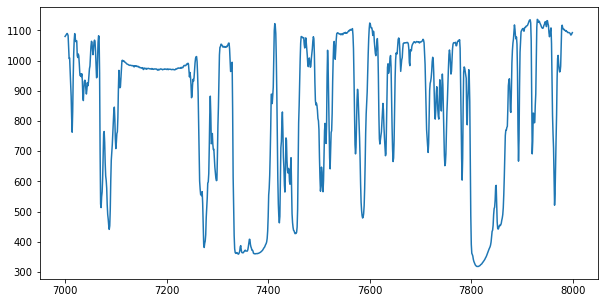

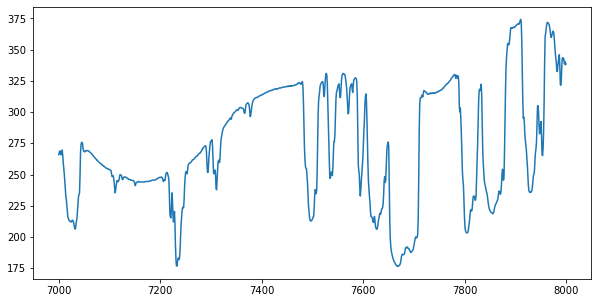

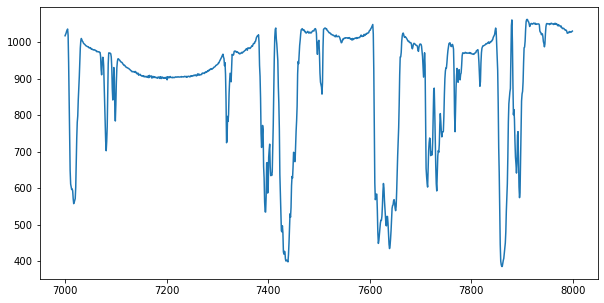

In [81]:
G = pd.read_csv("20111001_data.csv", header = 0)
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(G["s1"].iloc[7000:8000])
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(G["s6"].iloc[7000:8000])
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(G["s8"].iloc[7000:8000])
G1 = G["s1"].iloc[7000:8000].to_numpy().reshape(-1)
G6 = G["s6"].iloc[7000:8000].to_numpy().reshape(-1)
G8 = G["s8"].iloc[7000:8000].to_numpy().reshape(-1)

PV = pv.pv_panel(10,10)
print(PV.find_opt(1000,30+273))
# print(PV.solve_i(1200,30+273,10,100)[0]*100)
# print(PV.solve_i(1200,30+273,10,250)[0]*250)

P1max,P6max,P8max = [],[],[]
for k in range(G6.shape[0]): 
    P1max.append([k+0.01,PV.find_opt(G1[k],30+273)[0]/S_rated])
    P6max.append([k+0.01,PV.find_opt(G6[k],30+273)[0]/S_rated])
    P8max.append([k+0.01,PV.find_opt(G8[k],30+273)[0]/S_rated])
np.savetxt("Input/P1max.csv", P1max, delimiter=",") 
np.savetxt("Input/P6max.csv", P6max, delimiter=",") 
np.savetxt("Input/P8max.csv", P8max, delimiter=",") 

In [172]:
Xf,Xt,Xv,Yf,Yt,Yv,Yf_pred,Yt_pred,Yv_pred,err = [],[],[],[],[],[],[],[],[],[]
Lambda = [1] 
Wf,Wt,Wv = R_eq_f*np.r_[np.ones((5,1)),np.zeros((5,1))],np.zeros((10,1)),R_eq_v*np.r_[np.zeros((5,3)),np.ones((5,3))]
Pf,Pt,Pv = 1000*np.identity(Wf.shape[0]),1000*np.identity(Wt.shape[0]),1000*np.identity(Wv.shape[0])
P49_ref = 0.66
#### Estimate Sensitivities
def sensitivity(start):
    lmbda = 0.85
    
    dVolt = [x-y for x,y in zip(Voltages.iloc[-1].tolist()[1:],Voltages.iloc[-10].tolist()[1:])]
    dFreq = [sum(Frequencies.iloc[-1].tolist()[1:])/5.0-sum(Frequencies.iloc[-10].tolist()[1:])/5.0]
    dP49 = [Active_power.iloc[-1].tolist()[-1]-Active_power.iloc[-10].tolist()[-1]]
    Yf.append(dFreq)
    Yt.append(dP49)
    Yv.append(dVolt)
    
    Xf.append([P1_array[-1][1],P2_array[-1][1],P3_array[-1][1],P6_array[-1][1],P8_array[-1][1]])
    Xf[-1].extend([Q1_array[-1][1],Q2_array[-1][1],Q3_array[-1][1],Q6_array[-1][1],Q8_array[-1][1]])
    Xt.append([P1_array[-1][1],P2_array[-1][1],P3_array[-1][1],P6_array[-1][1],P8_array[-1][1]])
    Xt[-1].extend([Q1_array[-1][1],Q2_array[-1][1],Q3_array[-1][1],Q6_array[-1][1],Q8_array[-1][1]])    
    Xv.append([P1_array[-1][1],P2_array[-1][1],P3_array[-1][1],P6_array[-1][1],P8_array[-1][1]])
    Xv[-1].extend([Q1_array[-1][1],Q2_array[-1][1],Q3_array[-1][1],Q6_array[-1][1],Q8_array[-1][1]])
            
    Yf_pred.append(list(np.dot(np.array(Xf[-1]),Wf)))
    Yt_pred.append(list(np.dot(np.array(Xt[-1]),Wt)))
    Yv_pred.append(list(np.dot(np.array(Xv[-1]),Wv)))
    # Least Squares
#     X,Y = np.array(Xf),np.array(Yf)
#     L = Lambda[::-1]
#     Sf = multi_dot([np.linalg.pinv(np.dot(X.T*np.array(L),X)),X.T*np.array(L),Y])
#     X,Y = np.array(Xt),np.array(Yt)
#     St = multi_dot([np.linalg.pinv(np.dot(X.T*np.array(L),X)),X.T*np.array(L),Y])
#     X,Y = np.array(Xv),np.array(Yv)
#     Sv = multi_dot([np.linalg.pinv(np.dot(X.T*np.array(L),X)),X.T*np.array(L),Y])
#     Lambda.append(Lambda[-1]*lmbda)
    # Recursive Least Squares  
    X,Y = np.array(Xf),np.array(Yf)
    m = lmbda+multi_dot([X[-1].T,Pf,X[-1]])
    Pf_new = Pf/lmbda - multi_dot([Pf,np.reshape(X[-1],(-1, 1)),np.reshape(X[-1],(1, -1)),Pf])/m/lmbda       
    for i in range(Y.shape[1]):        
        Wf[:,i] = Wf[:,i] + np.dot(Pf_new,X[-1])*(Y[-1]-np.dot(X[-1],Wf[:,i]))
        
    X,Y = np.array(Xt),np.array(Yt)
    m = lmbda+multi_dot([X[-1].T,Pt,X[-1]])
    Pt_new = Pt/lmbda - multi_dot([Pt,np.reshape(X[-1],(-1, 1)),np.reshape(X[-1],(1, -1)),Pt])/m/lmbda       
    for i in range(Y.shape[1]):        
        Wt[:,i] = Wt[:,i] + np.dot(Pt_new,X[-1])*(Y[-1]-np.dot(X[-1],Wt[:,i]))
        
    X,Y = np.array(Xv),np.array(Yv)
    m = lmbda+multi_dot([X[-1].T,Pv,X[-1]])
    Pv_new = Pv/lmbda - multi_dot([Pv,np.reshape(X[-1],(-1, 1)),np.reshape(X[-1],(1, -1)),Pv])/m/lmbda       
    for i in range(Y.shape[1]):        
        Wv[:,i] = Wv[:,i] + np.dot(Pv_new,X[-1])*(Y[-1,i]-np.dot(X[-1],Wv[:,i]))
    
    err.append([100*abs(x-y)/max(abs(x),1e-4) for x,y in zip(Yf[-1],Yf_pred[-1])]+\
               [100*abs(x-y)/max(abs(x),1e-4) for x,y in zip(Yt[-1],Yt_pred[-1])]+\
               [100*abs(x-y)/max(abs(x),1e-4) for x,y in zip(Yv[-1],Yv_pred[-1])])
    print(f"error is {err[-1]}")
    
    for i in range(Pf_new.shape[1]):
        Pf[:,i] = Pf_new[:,i]
    for i in range(Pt_new.shape[1]):
        Pt[:,i] = Pt_new[:,i]
    for i in range(Pv_new.shape[1]):
        Pv[:,i] = Pv_new[:,i]
    
#### Solve optimization to compute secondary control input adjustment
def control_perturb(k): ### k - time instant
    np.random.seed(k)
    ave_freq = sum(Frequencies.iloc[-1].tolist()[1:])/5.0
    P1,P2,P3,P6,P8,P49 = Active_power.iloc[-1].tolist()[1:]
    P1ref,P6ref,P8ref = SolarPowerSetpoints.iloc[-1].tolist()[1:]
#     P49 = Active_power.iloc[-1].tolist()[-1]
    ave_volt = sum(Voltages.iloc[-1].tolist()[1:])/3.0       
#     if k%4==2: y = y - y*np.random.uniform(0,0.5,size=(5,))
    I = np.identity(10)
    if P49>P49_ref:
        A = np.r_[Wf.T,Wt.T,Wv.T]
        D = np.diag([1,3,1,1,1])
        y = np.array([60-ave_freq]+[P49_ref-P49]+[1-Voltages.iloc[-1].tolist()[1]]+\
                     [0.95-Voltages.iloc[-1].tolist()[2]]+[0.96-Voltages.iloc[-1].tolist()[3]])
    else:
        A = np.r_[Wf.T,Wv.T]
        D = np.diag([3,1,1,1])
        y = np.array([60-ave_freq]+[1-Voltages.iloc[-1].tolist()[1]]+\
                     [0.95-Voltages.iloc[-1].tolist()[2]]+[0.96-Voltages.iloc[-1].tolist()[3]])
    P = multi_dot([A.T,D,A])
    q = multi_dot([-2*A.T,D,y])
    G = np.r_[I,-I]
    h = np.ones(20)*0.1-np.random.uniform(0,0.04,size=(20,))
    if h[0]>P1max[k][1]-P1ref: h[0] = P1max[k][1]-P1ref
    if h[10]>P1ref: h[10] = P1ref
    if -h[10]>h[0]: h[10] = -h[0]
    if h[3]>P6max[k][1]-P6ref: h[3] = P6max[k][1]-P6ref
    if h[13]>P6ref: h[13] = P6ref
    if -h[13]>h[3]: h[13] = -h[3]
    if h[4]>P8max[k][1]-P8ref: h[4] = P8max[k][1]-P8ref
    if h[14]>P8ref: h[14] = P8ref
    if -h[14]>h[4]: h[14] = -h[4]
    x = cp.Variable(10)
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, P) + q.T @ x),[G @ x <= h])
    prob.solve()
    nullA = null_space(A)
    i = np.random.randint(0,nullA.shape[1])
#     if k%4==2: return [x+np.random.uniform(0,0.05)*d for x,d in zip(list(x.value),null_space(A)[:,i])]
    if k%4==2: 
        u = [z+0.03*d for z,d in zip(list(x.value),nullA[:,i])]
        if u[0]>P1max[k][1]-P1ref or u[0]<0 or u[3]>P6max[k][1]-P6ref or u[3]<0 or u[4]>P8max[k][1]-P8ref or u[4]<0: return list(x.value)
        return u
    else: return list(x.value)

In [173]:
import xmlrpc.client
server = xmlrpc.client.ServerProxy("http://localhost:1080/RPC2")
server.plecs.load("IEEE14_v10.plecs")
import time

folder = "Input/"
np.savetxt(folder+"P1.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P2.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P3.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P6.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P8.csv", np.zeros((1,2)), delimiter=",")

np.savetxt(folder+"Q1.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q2.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q3.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q6.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q8.csv", np.zeros((1,2)), delimiter=",") 

P1_array,P2_array,P3_array,P6_array,P8_array,Q1_array,Q2_array,Q3_array,Q6_array,Q8_array = [[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]]
run = 1
k = 5
while run:
    time.sleep(0.01)
    tmp = pd.read_csv("Data/Frequencies.csv",index_col = False)
    if len(tmp.index):
        cur_time = tmp.iloc[-1].tolist()[0]
        if cur_time>=k: 
            print("#################################")
            print(f"Current time: {cur_time}")
            
            ### Collect measurements and apply control
            folder = "Data/"

            Frequencies = pd.read_csv(folder+"Frequencies.csv",index_col = False,header=None)
            Voltages = pd.read_csv(folder+"Voltages_load.csv",index_col = False,header=None)
            Voltages_gen = pd.read_csv(folder+"Voltages_gen.csv",index_col = False,header=None)
            Active_power = pd.read_csv(folder+"Active_power.csv",index_col = False,header=None)
            Reactive_power = pd.read_csv(folder+"Reactive_power.csv",index_col = False,header=None)
            Currents = pd.read_csv(folder+"Currents.csv",index_col = False,header=None)
            SolarPowerSetpoints = pd.read_csv(folder+"SolarPowerSetpoints.csv",index_col = False,header=None)
            
            dP1,dP2,dP3,dP6,dP8,dQ1,dQ2,dQ3,dQ6,dQ8 = control_perturb(k)
            ave_freq = sum(Frequencies.iloc[-1].tolist()[1:])/5.0
            ave_volt = sum(Voltages.iloc[-1].tolist()[1:])/3.0
#             P49 = Active_power.iloc[-1].tolist()[-1]
            P1,P2,P3,P6,P8,P49 = Active_power.iloc[-1].tolist()[1:]
            I1,I6,I8 = Currents.iloc[-1].tolist()[1:]
            print("Freq, tie line power, and voltages:")
            print(ave_freq,P49)
            print(Voltages.iloc[-1].tolist()[1:])
            print("Applied Control:")
            print(dP1,dP2,dP3,dP6,dP8,dQ1,dQ2,dQ3,dQ6,dQ8)
            print(f"Solar inverter 1 measurements at time {k}:")
            print(P1max[k][1],P1,I1)
            print(f"Solar inverter 6 measurements at time {k}:")
            print(P6max[k][1],P6,I6)
            print(f"Solar inverter 8 measurements at time {k}:")
            print(P8max[k][1],P8,I8)
            
            P1_array.append([cur_time+0.01,dP1])
            P2_array.append([cur_time+0.01,dP2])
            P3_array.append([cur_time+0.01,dP3])
            P6_array.append([cur_time+0.01,dP6])
            P8_array.append([cur_time+0.01,dP8])
            
            Q1_array.append([cur_time+0.01,dQ1])
            Q2_array.append([cur_time+0.01,dQ2])
            Q3_array.append([cur_time+0.01,dQ3])
            Q6_array.append([cur_time+0.01,dQ6])
            Q8_array.append([cur_time+0.01,dQ8])
            
            folder = "Input/"
            
            np.savetxt(folder+"P1.csv", np.array(P1_array), delimiter=",") 
            np.savetxt(folder+"P2.csv", np.array(P2_array), delimiter=",") 
            np.savetxt(folder+"P3.csv", P3_array, delimiter=",") 
            np.savetxt(folder+"P6.csv", P6_array, delimiter=",") 
            np.savetxt(folder+"P8.csv", P8_array, delimiter=",")

            np.savetxt(folder+"Q1.csv", Q1_array, delimiter=",") 
            np.savetxt(folder+"Q2.csv", Q2_array, delimiter=",") 
            np.savetxt(folder+"Q3.csv", Q3_array, delimiter=",") 
            np.savetxt(folder+"Q6.csv", Q6_array, delimiter=",") 
            np.savetxt(folder+"Q8.csv", Q8_array, delimiter=",") 
            
            ### Wait, collect measurements, estimate sensitivities
            wait = 1
            while wait:
                time.sleep(0.01)
                tmp = pd.read_csv("Data/Frequencies.csv",index_col = False)
                cur_time = tmp.iloc[-1].tolist()[0]
                if cur_time>=k+0.9: 
                    wait = 0
                    print(f"Current time: {cur_time}")            
                    folder = "Data/"

                    Frequencies = pd.read_csv(folder+"Frequencies.csv",index_col = False,header=None)
                    Voltages = pd.read_csv(folder+"Voltages_load.csv",index_col = False,header=None)
                    Voltages_gen = pd.read_csv(folder+"Voltages_gen.csv",index_col = False,header=None)
                    Active_power = pd.read_csv(folder+"Active_power.csv",index_col = False,header=None)
                    Reactive_power = pd.read_csv(folder+"Reactive_power.csv",index_col = False,header=None)
                    Sw_loads = pd.read_csv(folder+"Switchable_load.csv",index_col = False,header=None)
                
                    ave_freq = sum(Frequencies.iloc[-1].tolist()[1:])/5.0
                    P49 = Active_power.iloc[-1].tolist()[-1]
                    ave_volt = sum(Voltages.iloc[-1].tolist()[1:])/3.0
                    print("Freq, tie line power, and voltages:")
                    print(ave_freq,P49)
                    print(Voltages.iloc[-1].tolist()[1:])
                    
                    sensitivity(20)
                    print("Sensitivities:")
                    print(Wf[:,0])
                    print(Wt[:,0])
                    print(Wv[:,0])
                    
            if (k+1)%4 == 0: k+=2
            else: k+=1
            
        if cur_time==1000: run = 0

#################################
Current time: 5.0
Freq, tie line power, and voltages:
59.989593954713904 0.552082122419469
[0.9896444129902362, 0.9434820586461916, 0.9470115569082004]
Applied Control:
-0.015033792453458818 0.06262329144506125 0.06306556155026634 -0.012930505358950106 -0.010143878203782425 0.0755301892372659 0.06936356555927678 0.07926326294255533 0.08812805430361503 0.0924912704575635
Solar inverter 1 measurements at time 5:
1.1928731083044892 1.2174642296875495 0.7968355585191012
Solar inverter 6 measurements at time 5:
0.2377979121214164 0.257922616858165 0.748390061474016
Solar inverter 8 measurements at time 5:
1.1304559159432317 1.1477171959279513 0.789598323985961
Current time: 5.9
Freq, tie line power, and voltages:
59.99335545239385 0.5626783188444391
[0.9926100963367532, 0.9464396860498944, 0.949871634714731]
error is [176.6463300364097, 100.0, 69.82294778179995, 70.28550907473684, 76.0934919123226]
Sensitivities:
[ 0.12117459  0.10899482  0.10892545  0.1208

Current time: 13.9
Freq, tie line power, and voltages:
59.99859099539093 0.613433101386004
[0.997890519150152, 0.953536994291644, 0.9606159406007122]
error is [58.86790821283776, 692.406483421188, 17.62127279649706, 14.140447125171137, 15.945796697543942]
Sensitivities:
[ 0.11524936  0.09990491  0.11424563  0.11575957  0.11492231 -0.00981237
 -0.00452745 -0.01391228 -0.02363432 -0.01008411]
[ 0.04569664  0.04626569  0.06729164 -0.01599613 -0.09913878  0.00409316
  0.00398822 -0.00016215  0.01245706  0.00347537]
[ 0.00170978 -0.00199043 -0.00202778  0.00062921  0.00111696  0.00645727
  0.00492822  0.00785542  0.00914161  0.01080028]
#################################
Current time: 14.0
Freq, tie line power, and voltages:
59.998596981500825 0.6134416520480463
[0.9978861713703626, 0.9535309663984024, 0.9606113149569004]
Applied Control:
-0.04929230061570608 -0.015604735280873508 0.06518192966873877 -0.005332099071108062 0.0013681025977140481 -0.008930221465877616 0.0794724885691807 -0.0850

#################################
Current time: 22.0
Freq, tie line power, and voltages:
59.99923948574258 0.6158854169049593
[0.999361561919185, 0.9487542434085044, 0.9621500788692614]
Applied Control:
-0.04079684446414247 0.008328375620049453 0.044096060079632536 -0.0665739163853143 0.06982206719799944 -0.10232937287771561 -0.07187400719372344 0.09412393433068164 0.0886746383174281 -0.09501228238683945
Solar inverter 1 measurements at time 22:
1.1657005648642114 0.8433195278432032 0.9024578611132
Solar inverter 6 measurements at time 22:
0.18210380460921738 0.18343783436082275 0.6452184896946744
Solar inverter 8 measurements at time 22:
0.691412163016418 0.617395523968273 0.904582421552736
Current time: 22.9
Freq, tie line power, and voltages:
59.9996344668161 0.6123440845728271
[0.9991604843571004, 0.9496331100028838, 0.9621558698985454]
error is [92.71591047226985, 19.25091907329177, 173.1496775738124, 23.571896988703074, 326.57345926778794]
Sensitivities:
[ 0.1078665   0.10281941 

Current time: 30.9
Freq, tie line power, and voltages:
59.999981386704484 0.6095244077328957
[0.9991858036166796, 0.950261018116607, 0.9604024644299556]
error is [16.66072786337471, 4.254511243552449, 6.326318485325403, 10.8274225119557, 7.863109186958552]
Sensitivities:
[ 0.10418703  0.09959705  0.09750942  0.10485877  0.10163047 -0.00824504
 -0.00835233 -0.00830781 -0.02287638 -0.007879  ]
[ 0.05114207  0.05119241  0.05463014 -0.05649676 -0.10523467  0.00388829
  0.00300188  0.00388971  0.00654627  0.01051699]
[-0.00165243 -0.00165706 -0.00209165  0.00368645  0.0018243   0.00521082
  0.00564421  0.0054752   0.01357769  0.00903288]
#################################
Current time: 31.0
Freq, tie line power, and voltages:
59.999980922359406 0.6095275977777884
[0.9991858094613744, 0.9502609961371145, 0.9604024644067012]
Applied Control:
-0.0007696228784274393 -0.0007409071095131007 -0.0007298743075236161 0.0027334276483556644 -0.00033817190750508536 0.0004220162136625218 0.000467312689224

#################################
Current time: 39.0
Freq, tie line power, and voltages:
59.99982189694722 0.6360686015979568
[1.000259740206491, 0.9499999378093236, 0.9595578629707182]
Applied Control:
0.0003282184266766822 0.00023800487981802314 0.00023785132964918116 0.003057793741405984 -0.0013907617187579482 -7.043835087120772e-05 0.003652497341034812 0.001454634440296945 0.003967821525244637 -0.00654814726937555
Solar inverter 1 measurements at time 39:
1.010311684435561 0.7816106127129133 0.8429474051271354
Solar inverter 6 measurements at time 39:
0.2024942386177711 0.19538705703348336 0.7216938061664105
Solar inverter 8 measurements at time 39:
1.0797304365210563 0.6788372644137812 0.9222583338196604
Current time: 39.9
Freq, tie line power, and voltages:
59.99999581030793 0.6360793647632063
[1.0002868120258548, 0.9500946895545987, 0.959602485259426]
error is [2.392892529530264, 27.69430010194206, 2.2045388180221495, 0.7338134913866472, 2.042902026288344]
Sensitivities:
[ 0.104

Current time: 47.9
Freq, tie line power, and voltages:
60.00000004882777 0.6571851089560177
[1.0004742508163058, 0.9501390299565788, 0.9593136479732176]
error is [0.2826086291933576, 8.268655360424004, 0.23757884225551104, 0.5344603360183178, 0.2928388880158171]
Sensitivities:
[ 0.10414651  0.09927999  0.09600376  0.10383175  0.10080169 -0.00874866
 -0.0076714  -0.00862554 -0.02298643 -0.00770416]
[ 0.0524467   0.05107285  0.05244617 -0.05874829 -0.10537943  0.00297312
  0.00428093  0.00252798  0.00748714  0.01038974]
[-0.00135518 -0.00162681 -0.00293446  0.00371466  0.00158147  0.00512486
  0.00570393  0.00540147  0.01295959  0.00906591]
#################################
Current time: 49.0
Freq, tie line power, and voltages:
60.0339825776402 0.6308891461093714
[1.0087178009511408, 0.9638278415923448, 0.970969516458032]
Applied Control:
-0.07113398173736114 -0.08004878600366941 -0.08231148868423221 -0.06790277888782299 -0.06620674777040322 -0.09083447182349089 -0.061513298343830035 -0.

#################################
Current time: 57.0
Freq, tie line power, and voltages:
60.0312192007048 0.6060843340870848
[1.0075015156311224, 0.965553361340169, 0.9718011556731562]
Applied Control:
-0.09712784181801451 -0.0640588459928313 -0.05850329484842216 -0.038720220388399465 -0.0914338585649819 -0.08210057280867708 -0.08128544782458674 -0.0959745137225208 -0.06290848420791165 -0.09356052622629872
Solar inverter 1 measurements at time 57:
1.1617408088458783 0.7025425704219963 0.8454725227459075
Solar inverter 6 measurements at time 57:
0.24128581829335008 -0.0171586578088685 0.6799697772261413
Solar inverter 8 measurements at time 57:
1.0628358005116894 0.5094107870821521 0.8493719212978723
Current time: 57.9
Freq, tie line power, and voltages:
59.99985052958466 0.6044294758836533
[1.0044308410842353, 0.9627937873009532, 0.9689094447562496]
error is [1.2638914323016708, 8.794322577844193, 5.336165382988009, 6.272589154474883, 5.9027103234126175]
Sensitivities:
[ 0.10427212  0.

Current time: 65.9
Freq, tie line power, and voltages:
59.98326474709222 0.6704861983325515
[0.9860794236899726, 0.9227073931894993, 0.9412531063210404]
error is [2.3306373975042014, 11.623055564094747, 0.6903327550885174, 3.2472194159233063, 2.2986932941696305]
Sensitivities:
[ 0.10353653  0.09915187  0.09508237  0.10434733  0.10049373 -0.00748143
 -0.00878344 -0.00901898 -0.02105962 -0.00451946]
[ 0.05541261  0.05437439  0.04995523 -0.05816878 -0.10356634  0.00220867
  0.00789494  0.00137027  0.0038231   0.00713976]
[-0.00240288 -0.00143053 -0.00328429  0.00317682  0.00217314  0.00561228
  0.00636665  0.0052622   0.01341702  0.00975029]
#################################
Current time: 66.0
Freq, tie line power, and voltages:
59.98325817343639 0.6704709480834
[0.9860855331933432, 0.9227134997828836, 0.9412589464522202]
Applied Control:
0.001972667392955041 0.09863151296222718 -0.07147134040016209 -0.005071429841126942 0.09512581055917066 0.08356682021075558 0.06351889290039178 0.070050

#################################
Current time: 74.0
Freq, tie line power, and voltages:
59.99932402180434 0.634598420572589
[1.0020184242253545, 0.9461501902861028, 0.9600464396230391]
Applied Control:
0.027959520882118886 0.015594808498373029 0.03435396471011323 -0.002093907260304341 -0.055754902145331214 0.008428443894737382 0.06897048354915644 -0.06975677541536436 0.07134864720515939 -0.07341873743587898
Solar inverter 1 measurements at time 74:
0.6245703246970432 0.5746724050292632 0.9533950019570296
Solar inverter 6 measurements at time 74:
0.23392897469906815 0.2361932378615146 0.8448898458410657
Solar inverter 8 measurements at time 74:
1.037509071345904 0.9696942355623898 0.9358295693324724
Current time: 74.9
Freq, tie line power, and voltages:
60.00006890213886 0.6445737492012799
[1.0020653848126382, 0.9472101478591552, 0.9603484027284352]
error is [9.866860541146401, 3.04523253864318, 129.47331343830774, 4.944342589785275, 39.17818248061133]
Sensitivities:
[ 0.10447655  0.09

Current time: 82.9
Freq, tie line power, and voltages:
59.99992954538094 0.6601876513511266
[0.9983955909031684, 0.9516650436465716, 0.9607087544794372]
error is [1.3860821449205798, 2.883394446678508, 35.12153937340207, 7.737335527264675, 18.343591033331325]
Sensitivities:
[ 0.10456047  0.09793631  0.09564711  0.10734785  0.10178743 -0.00897262
 -0.00731017 -0.00889802 -0.02244322 -0.00697049]
[ 0.05367768  0.05149604  0.05208205 -0.05859239 -0.10375523  0.00245456
  0.00436614  0.00294212  0.00782745  0.01052699]
[-0.00110548 -0.00221416 -0.00310664  0.00506352  0.00206914  0.00533482
  0.00515475  0.00458391  0.01287861  0.01009634]
#################################
Current time: 83.0
Freq, tie line power, and voltages:
59.99993251701701 0.660175631055015
[0.9983948445616162, 0.9516617818093948, 0.9607073995247316]
Applied Control:
0.008002022779255375 0.005395990356392488 -0.0006775566551213958 -0.05687321966352769 0.04866039134721944 0.018381152055262265 0.08453119343819387 0.0702

#################################
Current time: 91.0
Freq, tie line power, and voltages:
59.99984257167874 0.6226392562251093
[0.9991190144118, 0.9498970202010608, 0.9608865973445776]
Applied Control:
-0.0005710788057350922 -0.0005502617321597612 -0.0005604431449518621 0.0034267157529248864 -0.0002539390854642534 0.0002026688021291144 0.0002404548332403755 0.000245042654340947 -1.9223077734416264e-05 0.000515695572285541
Solar inverter 1 measurements at time 91:
0.6957739271903607 0.23602344985434934 0.7455989404345147
Solar inverter 6 measurements at time 91:
0.22736757021636925 -0.0017672292481843387 0.7748534387292451
Solar inverter 8 measurements at time 91:
1.038446027069935 0.7919142642958246 0.9098256288898564
Current time: 91.9
Freq, tie line power, and voltages:
60.000008305120886 0.6223484659255587
[0.9991464393712014, 0.949922207286474, 0.9609148703087204]
error is [5.024941512260798, 11.252856357617771, 3.9698636769293167, 1.636456495985211, 3.045549267746634]
Sensitivities

Current time: 99.9
Freq, tie line power, and voltages:
59.999921741432956 0.6542944660119399
[1.001601403237445, 0.948693049039256, 0.9585670978692707]
error is [74.64853774668883, 0.88883761588223, 3.088258196392661, 3.5615637590335556, 3.3464767498772123]
Sensitivities:
[ 0.10560765  0.09946521  0.09538479  0.10568213  0.10291639 -0.00866946
 -0.00808717 -0.00886424 -0.02280451 -0.00743984]
[ 0.05455517  0.05234595  0.05197226 -0.05540922 -0.10547953  0.00147133
  0.00407065  0.00464975  0.00774574  0.01115115]
[-0.00104453 -0.00142411 -0.00287579  0.00454531  0.00231613  0.00478798
  0.00573103  0.00554269  0.01253755  0.00909726]
#################################
Current time: 101.0
Freq, tie line power, and voltages:
59.98989279594472 0.6552183561386015
[0.9999526481636288, 0.9459242050481418, 0.9559494644027422]
Applied Control:
0.06880966982504129 0.07717329652527442 -0.09272430389359684 -2.775558226842878e-17 0.0725889207321075 0.06664412549455695 0.08772135121311049 0.06425547

#################################
Current time: 109.0
Freq, tie line power, and voltages:
59.984046209490636 0.6464085791161686
[0.9991970179092547, 0.949468052828472, 0.9591035611352084]
Applied Control:
0.030879031600583265 0.032866702261247695 0.0331182440408933 0.03484994344496647 0.03302759469354893 0.0012608119751586944 0.023352622413998735 0.008483760715006297 0.0030643655164290843 0.06445538108163341
Solar inverter 1 measurements at time 109:
0.98382607887052 0.5134850284270853 0.8432628563492098
Solar inverter 6 measurements at time 109:
0.21546245692185506 0.18005830509924425 0.8341871784051575
Solar inverter 8 measurements at time 109:
1.023917132943207 0.7447589718932285 0.9227894340963426
Current time: 109.9
Freq, tie line power, and voltages:
59.999786230157454 0.6467974345695281
[0.9999942824697556, 0.9499479213941744, 0.9598033495499438]
error is [1.358123780272986, 60.58864960343473, 11.38799940411875, 16.58185207505104, 11.556509940377904]
Sensitivities:
[ 0.10437604 

Current time: 117.9
Freq, tie line power, and voltages:
60.000019931723365 0.6233367696363117
[0.9981131756499554, 0.9530865794176174, 0.9595173541363904]
error is [0.45049003508534197, 1.6246023260836386, 4.094921476837645, 3.677875749311518, 4.168569007215412]
Sensitivities:
[ 0.10507294  0.0971264   0.09437146  0.10393595  0.10066774 -0.00822488
 -0.0076975  -0.00870038 -0.02267647 -0.00700066]
[ 0.05591525  0.04888839  0.0505217  -0.0592142  -0.10752797  0.0008138
  0.00420735  0.00484365  0.00936519  0.01149962]
[-0.00123558 -0.00173793 -0.00257444  0.00402432  0.00121781  0.00471828
  0.00574705  0.00598279  0.01287755  0.0090287 ]
#################################
Current time: 118.0
Freq, tie line power, and voltages:
60.00002447095066 0.6233104003068678
[0.9981120092915924, 0.9530830978957044, 0.9595156189262246]
Applied Control:
-0.012959062339384517 -0.05953038448421828 -0.0006046886768069368 -0.0025491343266575203 0.0709374004783295 0.026848879169383624 0.023736078621106542

#################################
Current time: 126.0
Freq, tie line power, and voltages:
59.99985338298774 0.5527909123107362
[0.9964098112365188, 0.955910534407258, 0.9586830561856724]
Applied Control:
0.09650649387280785 -0.07367874098116667 -0.02586570789285368 -0.0002221387748694428 -0.0034409734885042925 -0.06169330779343504 0.10300422325474129 0.09389275290201798 -0.08150732268549744 0.07215523236250024
Solar inverter 1 measurements at time 126:
1.0695803421727479 0.2798585167138096 0.6701512721278315
Solar inverter 6 measurements at time 126:
0.2166112274702554 0.0010057511138372886 0.5982428685401641
Solar inverter 8 measurements at time 126:
1.0000239290954063 1.0008606274812144 1.0325509241607536
Current time: 126.9
Freq, tie line power, and voltages:
59.99993813469024 0.5539278648122077
[0.9968336463077726, 0.9550432313439912, 0.958790105335944]
error is [58.94251832506622, 13.01005757783909, 16.127432560131787, 10.126648950050367, 68.25691449546629]
Sensitivities:
[ 0.1044

Current time: 134.9
Freq, tie line power, and voltages:
59.99983237627983 0.56894108644025
[0.99690012464698, 0.9547550657802012, 0.9584004937340932]
error is [116.8654755707738, 0.003326492645133537, 8.098808213334943, 2.59126617939615, 30.69178675604216]
Sensitivities:
[ 0.10492318  0.09999934  0.09696411  0.10346098  0.10197104 -0.00921639
 -0.0092282  -0.0065788  -0.02131211 -0.00826216]
[ 0.05409765  0.05216744  0.05270428 -0.05739722 -0.10520531  0.0023401
  0.00350557  0.00417775  0.00672164  0.00936957]
[-0.00116594 -0.00197125 -0.00158889  0.00327287  0.00178132  0.0052886
  0.0058357   0.00616374  0.01397353  0.00840954]
#################################
Current time: 135.0
Freq, tie line power, and voltages:
59.999833224434994 0.5689612529567205
[0.9969008854867026, 0.9547525471824152, 0.958400390437743]
Applied Control:
0.0250688985933243 0.03121299276361135 -0.022019010969050887 -0.03240947869295595 0.0031300986230475693 0.09369912826723004 0.0791764749800838 0.06144240361

#################################
Current time: 143.0
Freq, tie line power, and voltages:
60.00001787624016 0.5771638589297304
[0.9994137807533222, 0.949771229951926, 0.960859293245746]
Applied Control:
-2.130374790989398e-05 -1.4082598828845213e-05 3.819694788902679e-06 -0.00021577121871699478 5.831439977588798e-05 -4.0030975138682667e-05 -4.2323696454448245e-05 -6.322942262079154e-05 9.64478280832036e-08 -9.774669247133563e-05
Solar inverter 1 measurements at time 143:
1.0644966795602084 0.5735244039523905 0.7652674168872726
Solar inverter 6 measurements at time 143:
0.2162278728627194 0.07609422968848754 0.37019741974815773
Solar inverter 8 measurements at time 143:
0.9850421547051763 0.9776870309822558 1.2387308880017958
Current time: 143.9
Freq, tie line power, and voltages:
59.999998954809634 0.5771712868938489
[0.9994116452436428, 0.9497693266374748, 0.9608571541595708]
error is [1.1030564410651862, 4.324614718455552, 0.1397283602596758, 0.1284049808425866, 0.13758922959218778]


Current time: 151.9
Freq, tie line power, and voltages:
60.00000091333582 0.5598293320171825
[0.9992548301291772, 0.949765682702136, 0.961044002864412]
error is [0.7448294320456408, 7.740335039095913, 0.020821829087416515, 0.06587859832517018, 0.0012309306174195242]
Sensitivities:
[ 0.1051078   0.09958076  0.09567775  0.10355156  0.10220348 -0.00859331
 -0.00976249 -0.00865027 -0.0218235  -0.00669769]
[ 0.05396844  0.05216104  0.0524557  -0.05677711 -0.10593625  0.00255882
  0.00300837  0.00342915  0.0061041   0.0097781 ]
[-0.00057065 -0.00153234 -0.00193604  0.00369389  0.00166844  0.00450453
  0.00558057  0.00613915  0.01398736  0.00817348]
#################################
Current time: 153.0
Freq, tie line power, and voltages:
60.01702017090455 0.5392126736993296
[1.0045876094162438, 0.9552906989116332, 0.9683394563278092]
Applied Control:
-0.06940642784262316 -0.05952383019028122 0.08025321525897557 -0.0836618227813812 -0.07293199924884428 -0.07781422428506111 -0.09242448414225482

Current time: 159.9
Freq, tie line power, and voltages:
59.99981831135458 0.5681189251106942
[0.99934614352046, 0.9491925655109545, 0.9612149245898098]
error is [181.6433861588397, 4.271900041967583, 14.74651122399085, 5.391652275273236, 36.10985795152106]
Sensitivities:
[ 0.10527135  0.09924689  0.09529948  0.103811    0.10214012 -0.00953479
 -0.00933929 -0.00808429 -0.02188863 -0.00675298]
[ 0.05481224  0.05264559  0.05238645 -0.05674451 -0.10511138  0.00185485
  0.00297169  0.00293168  0.00478051  0.0090034 ]
[-6.91105766e-05 -1.85310526e-03 -2.03442547e-03  3.72124898e-03
  1.97536101e-03  4.36315567e-03  5.50455154e-03  6.05587377e-03
  1.37334715e-02  8.27302060e-03]
#################################
Current time: 161.0
Freq, tie line power, and voltages:
59.997159597257905 0.5769592515528114
[0.9975045241423912, 0.9504469325573844, 0.9599992948770948]
Applied Control:
0.061877514119861934 -0.05419961332082792 -0.07089692299149063 -1.3353713314798817e-06 0.09091707969851608 0.075

Current time: 167.9
Freq, tie line power, and voltages:
59.999998547502855 0.5628813335743093
[0.998795264704712, 0.9496125204028406, 0.9616615528834968]
error is [1.550816200635809, 0.3438315800691939, 0.30337787694206847, 0.21340519471651398, 0.31306107885435985]
Sensitivities:
[ 0.10521632  0.09918649  0.09540959  0.10393039  0.10222951 -0.00940152
 -0.00924338 -0.00826725 -0.02197869 -0.00659433]
[ 0.05478247  0.05237655  0.05244467 -0.05638309 -0.1049693   0.00196865
  0.00314193  0.00248138  0.00464355  0.0093451 ]
[-0.00021583 -0.00201426 -0.00218329  0.00411518  0.00213094  0.00451821
  0.00578847  0.00568456  0.0133834   0.00819382]
#################################
Current time: 169.0
Freq, tie line power, and voltages:
60.01384891007276 0.5439942259471592
[1.0023182772850514, 0.9636610394688494, 0.9712611626531606]
Applied Control:
-0.0841822698094321 0.01288401943934901 0.07328290477375578 -0.081150323193924 -0.09307417231298809 -0.07620758315563132 -0.09928378670475237 -0.

#################################
Current time: 177.0
Freq, tie line power, and voltages:
59.999845662127896 0.527945231633895
[0.996604885347306, 0.9502746119406312, 0.9629202382990952]
Applied Control:
0.0016088835149400305 -0.07820080617458636 0.02181161022242987 -3.620785561517979e-06 0.06639458930669837 0.07491065902847208 0.07801639406699222 0.08918634655083833 -0.0933744288092732 0.08380622312239927
Solar inverter 1 measurements at time 177:
1.0548964297932855 0.3805462335468375 0.6735781242740051
Solar inverter 6 measurements at time 177:
0.21507934304300652 0.0015482723717120876 0.3101880394696193
Solar inverter 8 measurements at time 177:
0.9738175672385896 0.9065893595485645 1.14026883916138
Current time: 177.9
Freq, tie line power, and voltages:
60.000092880869445 0.5188503618602403
[0.9973679488227322, 0.9494161293736167, 0.9632534591289224]
error is [37.0120779334236, 0.051452270456318595, 1.6004743884265382, 1.7460499627097157, 3.4520521150567935]
Sensitivities:
[ 0.1056

#################################
Current time: 185.0
Freq, tie line power, and voltages:
60.007959327777726 0.501226495695562
[0.998171095073698, 0.9522483748032649, 0.9642053381811604]
Applied Control:
-0.03769045399800458 -0.045457956940173 -0.02601918295154448 1.2654562714326423e-06 0.007422579217979663 -0.06788457260862939 -0.020988322484561638 -0.027833974839148092 -0.08596229263239584 0.07229034012016314
Solar inverter 1 measurements at time 185:
1.0526374097731448 0.3588887044021832 0.6788570921232061
Solar inverter 6 measurements at time 185:
0.2162278728627194 -0.012188415294614495 0.2808702835588479
Solar inverter 8 measurements at time 185:
0.9728813965263999 0.9474650236354526 1.1405642794222806
Current time: 185.9
Freq, tie line power, and voltages:
59.9999519684539 0.4945565958268468
[0.9969775267297386, 0.9499807300403876, 0.9627733577993542]
error is [0.6349675758855216, 0.9772087847831996, 13.233749408716745, 8.618213018539148, 12.137292503951615]
Sensitivities:
[ 0.1

#################################
Current time: 193.0
Freq, tie line power, and voltages:
59.98581363402716 0.537417325545279
[0.9914722682291904, 0.9336243457489, 0.9522942536669592]
Applied Control:
0.08392045280794387 0.06769173490248515 -0.08020963227526147 0.09635663071180758 0.004173700757899136 0.07899816195839761 0.07591265294223569 0.08971322083797456 0.08873019013232501 0.08861186607011172
Solar inverter 1 measurements at time 193:
1.053206042560205 0.4044716224880795 0.684821218375698
Solar inverter 6 measurements at time 193:
0.21699360858409764 0.030523506039071193 0.23157153128363184
Solar inverter 8 measurements at time 193:
0.9710103462744534 0.9958430922928556 1.1898516288348011
Current time: 193.9
Freq, tie line power, and voltages:
59.999621052636066 0.5375767797717571
[0.9953119257941184, 0.9378316726981422, 0.956165805627041]
error is [1.749149555567517, 88.0750154253258, 2.446934818656524, 4.691232793332415, 2.9288019655025805]
Sensitivities:
[ 0.10642878  0.09943

Current time: 201.9
Freq, tie line power, and voltages:
59.999991873724866 0.5469222068868312
[0.997941815469921, 0.9496622163553312, 0.962917858386058]
error is [0.23109189275875747, 3.215171150899326, 3.566962749687809, 4.050799316870096, 3.832279555580916]
Sensitivities:
[ 0.10694671  0.10035269  0.09561832  0.1020437   0.10255485 -0.00911775
 -0.01036539 -0.00806623 -0.01948996 -0.0066999 ]
[ 0.05590383  0.05420307  0.05181301 -0.05733333 -0.10600306  0.0022163
  0.0030576   0.00130434  0.0054987   0.00996385]
[ 0.00054447 -0.00053018 -0.00265994  0.00167817  0.00199579  0.00496237
  0.00529264  0.00508603  0.01542347  0.00909734]
#################################
Current time: 202.0
Freq, tie line power, and voltages:
60.00000106206623 0.5469204066997141
[0.9979359522341807, 0.9496551059700638, 0.962911793381854]
Applied Control:
-0.06539973868213503 0.09346940981752631 0.026690509618827657 -0.09673143207949182 0.05610786236576134 -0.067780622577808 0.10272621699476993 0.092084278

Current time: 209.9
Freq, tie line power, and voltages:
59.99994519194494 0.5161283032007133
[0.9955072373867228, 0.9545966186631148, 0.9623472950194016]
error is [0.5460882471476958, 2.341153168384865, 0.7471494395376249, 2.179715948744604, 1.3765068468541863]
Sensitivities:
[ 0.10787119  0.10014716  0.09570257  0.10116626  0.10258224 -0.00874328
 -0.01045842 -0.0086938  -0.0189482  -0.00636386]
[ 0.05449062  0.05452933  0.05199716 -0.05472398 -0.10589683  0.00190418
  0.0031699   0.00242103  0.00381009  0.00869512]
[ 0.00021328 -0.00044836 -0.00246426  0.00303803  0.00212773  0.00500047
  0.00542532  0.00528349  0.0145532   0.008383  ]
#################################
Current time: 210.0
Freq, tie line power, and voltages:
59.999949303463836 0.5161329627352311
[0.9955029689992012, 0.9545905543085093, 0.9623427363611537]
Applied Control:
-0.06891751596750165 -0.002146194132331562 0.021668142296121583 0.0008548691166041624 0.054771138539784416 -0.009954827015572909 0.09200769177668792

#################################
Current time: 218.0
Freq, tie line power, and voltages:
59.98949974352185 0.568414389025023
[0.9850661419859909, 0.928853085763622, 0.9429932921606166]
Applied Control:
0.08046212273427605 0.08875376452746839 -0.09411170573424144 0.06826175206340976 -0.0037428831697873992 0.08607280462592379 0.07479099939735409 0.08330945891471199 0.09946220161624304 0.09425335529467764
Solar inverter 1 measurements at time 218:
1.0549000213492958 0.11647824836955582 0.7033323386894685
Solar inverter 6 measurements at time 218:
0.2040141528762727 0.09437662375016094 0.13889631397035465
Solar inverter 8 measurements at time 218:
0.9733494778446714 0.99473726714504 1.2873597128559426
Current time: 218.9
Freq, tie line power, and voltages:
59.99946261790986 0.5715034806732634
[0.9890165396286938, 0.9333452895484191, 0.9469935525836491]
error is [3.270100121957871, 10.838930935094325, 2.29717816478533, 5.348213006953015, 2.8028825892964027]
Sensitivities:
[ 0.10699078  0.1

Current time: 226.9
Freq, tie line power, and voltages:
60.00016886639596 0.579563898291071
[1.0003071141272744, 0.9518114121514712, 0.9586396853143436]
error is [46.92214609743273, 4.180380955129709, 15.182845426141924, 6.337760847425201, 12.577784318603802]
Sensitivities:
[ 0.10720906  0.10057541  0.09574658  0.10194517  0.09763129 -0.00890104
 -0.00907019 -0.00853723 -0.02277327 -0.00885746]
[ 0.05444307  0.05239309  0.05122289 -0.05691651 -0.10822332  0.0022452
  0.003033    0.00322536  0.00571807  0.00965045]
[-0.00011265 -0.00125852 -0.00156489  0.00343156  0.00062646  0.00496493
  0.00571885  0.00568934  0.01480851  0.00774049]
#################################
Current time: 227.0
Freq, tie line power, and voltages:
60.000177927420324 0.579567909089945
[1.000304417759927, 0.9518057992109408, 0.9586362336126596]
Applied Control:
-0.0010470908573424341 0.02581388298436211 -0.031147957517958985 -0.03789402371570248 0.0473854566664516 0.06698018713607 0.014210356607643053 0.07141117

Current time: 234.9
Freq, tie line power, and voltages:
60.000004668133535 0.591475152808449
[1.0007558656816429, 0.9488015189508254, 0.9600487497694298]
error is [1.0098964592416204, 0.24492487226907822, 9.259526078316398, 10.827516442197942, 20.33465264064768]
Sensitivities:
[ 0.10446423  0.09845671  0.09422792  0.1017987   0.10018329 -0.00728574
 -0.00938009 -0.01002846 -0.02260129 -0.00677332]
[ 0.0545389   0.05209988  0.05177693 -0.05766088 -0.10750774  0.00260777
  0.00329693  0.00313947  0.00606348  0.00954893]
[-0.00187938 -0.00172948 -0.00274653  0.00335262  0.00156129  0.00509212
  0.00541768  0.00499205  0.0155096   0.0086481 ]
#################################
Current time: 235.0
Freq, tie line power, and voltages:
60.00000481970168 0.5914995225098368
[1.0007541195069196, 0.9488026658581402, 0.960047800957978]
Applied Control:
-0.0047804071775219455 -0.033372216353683704 0.09689254503212356 0.0065787601785319404 -0.06271829651697258 -0.050434537555706795 -0.0810504390586573

#################################
Current time: 243.0
Freq, tie line power, and voltages:
59.99945728681274 0.6502731110142695
[1.0042155685161522, 0.9624112478967048, 0.9664611872943064]
Applied Control:
-0.060683578604600344 0.02778880799302138 0.07572404423590587 0.003531827960286227 -0.0739284747742296 -0.06734243091221631 -0.08698753043697266 -0.07654552510253569 -0.09576111260502443 -0.06211787727935854
Solar inverter 1 measurements at time 243:
1.0741028937131825 0.31572763375877977 0.7062367047127605
Solar inverter 6 measurements at time 243:
0.19037793139346798 -0.0011338982644758082 0.38599622866805855
Solar inverter 8 measurements at time 243:
0.975691199504495 0.4293326586879825 1.2389161895698375
Current time: 243.9
Freq, tie line power, and voltages:
59.999917138282946 0.6579350442256786
[1.0005862487768191, 0.9585285114643408, 0.9628863868487968]
error is [30.998063766788608, 1.3229837286410349, 5.896618204637883, 3.829609849474846, 5.452098502576162]
Sensitivities:
[ 0.

Current time: 251.9
Freq, tie line power, and voltages:
59.99999370776625 0.6509549823646729
[0.9988391686952844, 0.9501697266103984, 0.960877197007394]
error is [6.179684280531755, 0.6710340176053295, 0.2388136913474774, 0.4344468684549522, 0.2229798775518089]
Sensitivities:
[ 0.10429803  0.09643374  0.09346507  0.10305035  0.10162412 -0.007493
 -0.00843563 -0.0084324  -0.02039513 -0.0060545 ]
[ 0.05560753  0.05072592  0.05129397 -0.05623179 -0.10676944  0.00244962
  0.00390225  0.00407439  0.00569637  0.0093135 ]
[-0.0005931  -0.00250252 -0.00306883  0.00329599  0.00263644  0.00485584
  0.00615785  0.00526962  0.01462994  0.00759667]
#################################
Current time: 253.0
Freq, tie line power, and voltages:
59.96913050850801 0.6569913950638987
[0.9944662520643353, 0.936060258177768, 0.954546864428096]
Applied Control:
0.08951760515042609 0.07266030615750867 0.00735710881631038 0.07968844826684579 0.09812318709609114 0.07516035104417138 0.09542598470150539 0.08887108006

#################################
Current time: 261.0
Freq, tie line power, and voltages:
60.03117992247709 0.6489830478157202
[1.0041822804234706, 0.9604881703098732, 0.9737272279704132]
Applied Control:
-0.08442246564225907 -0.09695885082888249 -0.057029960844947325 -0.02415958220948837 -0.09195178616242498 -0.09778068745260791 -0.09089773815069886 -0.08009596533544092 -0.07186721123422143 -0.08705699431779249
Solar inverter 1 measurements at time 261:
1.0334480268822974 0.1924172371630115 0.7119671156986485
Solar inverter 6 measurements at time 261:
0.23160922410016546 -0.027890014151712897 0.2602177260052809
Solar inverter 8 measurements at time 261:
0.9831786414112592 0.2281224908192318 1.2457448745945576
Current time: 261.9
Freq, tie line power, and voltages:
59.999674157029254 0.6453833490784373
[1.0009705957022672, 0.9572807925494602, 0.9706055365474062]
error is [1.8169908886188741, 0.7994097143497929, 5.638585930254477, 6.154028498958861, 6.433139907829303]
Sensitivities:
[ 0

Current time: 269.9
Freq, tie line power, and voltages:
60.000133450073506 0.6451282681389956
[0.9976421483040624, 0.949194953495854, 0.963229697385631]
error is [40.43967071488803, 24.085187955229934, 3.7465289360751837, 11.07934455185533, 5.3477418988492005]
Sensitivities:
[ 0.101396    0.09912288  0.09428205  0.10259045  0.10101803 -0.00757938
 -0.00774934 -0.00757325 -0.01791452 -0.00553694]
[ 0.05502099  0.05217213  0.05044773 -0.05678619 -0.10543644  0.00289119
  0.00331168  0.00302166  0.00538325  0.009401  ]
[-0.00146957 -0.0013896  -0.00301913  0.00150378  0.00342125  0.00534382
  0.00600688  0.00554645  0.01579548  0.00794328]
#################################
Current time: 270.0
Freq, tie line power, and voltages:
60.00013397850729 0.64512790195325
[0.9976422031715316, 0.94919497953343, 0.9632297415029938]
Applied Control:
-0.002226856024722482 0.024023362206503963 -0.013022930733307621 -0.01041521737693785 4.611234071302863e-05 -0.0024743424185178302 -0.002586211982797249 -

Current time: 277.90000000000003
Freq, tie line power, and voltages:
60.0002910771427 0.6491530789096694
[1.0002228150592565, 0.9569204766933924, 0.9664918069915216]
error is [0.4525413843157399, 1.9743715760830878, 2.0560912993865785, 1.2810014888644918, 1.8767369486734315]
Sensitivities:
[ 0.10388903  0.09896231  0.09295894  0.1037571   0.10165567 -0.00823253
 -0.00807035 -0.00805583 -0.0194199  -0.00719166]
[ 0.05500742  0.05300924  0.05021566 -0.05689795 -0.10590634  0.00290265
  0.00340676  0.00324157  0.00538122  0.00983025]
[-0.00087652 -0.00129908 -0.00365621  0.00198309  0.00319809  0.00524101
  0.00585371  0.0054542   0.01535069  0.00781464]
#################################
Current time: 278.0
Freq, tie line power, and voltages:
60.00029762848349 0.6491447201402629
[1.0002164034271486, 0.9569137287478652, 0.9664855493894916]
Applied Control:
-0.017524614252939087 -0.004324007607106679 0.06504770069799859 -0.005498545374326704 -0.073761051225861 -0.09312661231522519 -0.070543

Current time: 285.9000000000001
Freq, tie line power, and voltages:
60.000020119210106 0.6402133631773466
[0.998305987208744, 0.948159258112441, 0.96348060808041]
error is [0.32112340063195666, 2.4218511251450336, 3.2768584423062936, 2.4830184283479735, 2.9399574468988354]
Sensitivities:
[ 0.10399757  0.09907324  0.09256009  0.10355788  0.1026667  -0.00813805
 -0.00803358 -0.00876466 -0.01920396 -0.00756948]
[ 0.05462661  0.05260057  0.05070499 -0.05645631 -0.10449028  0.00296332
  0.00357789  0.00292572  0.00532608  0.00901813]
[-0.00125777 -0.00174509 -0.00358878  0.00231066  0.00416905  0.00543006
  0.00595725  0.00534202  0.01533445  0.0074017 ]
#################################
Current time: 286.0
Freq, tie line power, and voltages:
60.000012039998126 0.640203722580009
[0.998310471340745, 0.9481659159610912, 0.963485579551404]
Applied Control:
-0.011671089863413985 0.09526268508438887 0.09154973625572076 -0.06782130924934286 -0.08576905572235331 0.08115723221350064 0.0212168660802

Current time: 293.9000000000001
Freq, tie line power, and voltages:
60.00016400678245 0.6690640953632376
[0.9975997455615312, 0.9484215821443072, 0.9646827220172374]
error is [2.427573706692064, 0.04687487408310591, 2.4620544201707566, 5.158778476016887, 3.0205534063113624]
Sensitivities:
[ 0.10540006  0.09864369  0.09335339  0.10285484  0.10245449 -0.0085601
 -0.00812161 -0.00783228 -0.01969181 -0.00791848]
[ 0.05501239  0.05212945  0.05087123 -0.05589012 -0.10542281  0.00371297
  0.0030179   0.00290374  0.00562698  0.00971358]
[-0.00101355 -0.00234842 -0.00299159  0.00220486  0.00389761  0.00531184
  0.00588089  0.00552386  0.01571197  0.00754713]
#################################
Current time: 294.0
Freq, tie line power, and voltages:
60.00016980668748 0.669104699411633
[0.99759437583109, 0.948417342046136, 0.9646777277881884]
Applied Control:
-0.08575276007153373 -0.016075509063904946 0.05964040377486374 -0.0341718208837133 0.07088302249813168 -0.07042604265027823 -0.09534911243971

Current time: 301.9000000000001
Freq, tie line power, and voltages:
60.000133388247534 0.6134542566384183
[0.9971156364301929, 0.9496491575913356, 0.9634412488873476]
error is [0.55342123605912, 10.028066251535693, 0.07812316614529007, 0.8092801392269826, 0.17503928338192395]
Sensitivities:
[ 0.10582746  0.09991004  0.09378598  0.10402399  0.10188599 -0.00839986
 -0.0084883  -0.00823103 -0.02094932 -0.00708503]
[ 0.05496083  0.05300432  0.05151854 -0.05537865 -0.10499321  0.00299116
  0.00356494  0.00283293  0.00532928  0.01012   ]
[-0.00098786 -0.00198143 -0.00288004  0.00286107  0.00336064  0.00549356
  0.00567827  0.00517398  0.01528793  0.00800517]
#################################
Current time: 302.0
Freq, tie line power, and voltages:
60.000136596462845 0.6134648308345786
[0.9971126333141694, 0.949644349105925, 0.9634377744299004]
Applied Control:
-0.0048257787868244886 0.004177499294979643 0.006392987857629597 -0.0008499522357702603 -0.0047355534436098155 -0.00276151702889003 -0

Current time: 309.9000000000001
Freq, tie line power, and voltages:
59.99990536942281 0.5719666573309788
[0.9946189163214256, 0.9514758823765148, 0.9644564619732736]
error is [3.23451717858905, 0.45930642635056274, 13.454414855523718, 3.4313960500195173, 8.66073234884642]
Sensitivities:
[ 0.10615582  0.10013431  0.09345903  0.10293773  0.1015467  -0.00882745
 -0.0082689  -0.00754254 -0.01988747 -0.00652395]
[ 0.05576506  0.05229193  0.0514932  -0.05524141 -0.10503598  0.00269345
  0.00302019  0.0037238   0.00499976  0.00902627]
[-0.00101249 -0.00156582 -0.00338509  0.0020665   0.00299635  0.00507977
  0.00577649  0.0058277   0.01597464  0.00824308]
#################################
Current time: 310.0
Freq, tie line power, and voltages:
59.99991171116592 0.5719290035483777
[0.9946178031531137, 0.9514725296080724, 0.9644547682611408]
Applied Control:
-0.004399037028975915 -0.09326665057457711 0.04045470411355902 -0.0017640475960703642 0.06427137439544169 -0.03084296889000116 0.124343116

Current time: 317.9000000000001
Freq, tie line power, and voltages:
59.999874906791796 0.5778466416355627
[0.9963026728978532, 0.9481747468321142, 0.965684907677111]
error is [26.661827738060698, 0.5555675825826616, 4.423436218522302, 19.365811881605094, 5.008955851436162]
Sensitivities:
[ 0.10560816  0.10060693  0.09358258  0.10362395  0.10158416 -0.00807604
 -0.00869203 -0.00860636 -0.01983133 -0.00591471]
[ 0.05533594  0.05346538  0.05130178 -0.05654778 -0.1056055   0.00250247
  0.0029169   0.00304633  0.00513705  0.00988191]
[-0.00173151 -0.00136859 -0.00353053  0.00258257  0.00327274  0.00482225
  0.00608366  0.00644226  0.01575573  0.00791586]
#################################
Current time: 318.0
Freq, tie line power, and voltages:
59.99987647841762 0.5778924911042334
[0.9962991831338768, 0.9481738732957908, 0.965682139657021]
Applied Control:
-0.0038553785205155716 0.00561674340745506 0.008074108645626788 -0.001967517873151295 -0.004639265991112596 -0.0028426174896372383 0.02622

Current time: 325.9000000000001
Freq, tie line power, and voltages:
59.99985343387082 0.5654023555738505
[0.997349100515134, 0.9477923612735824, 0.9704186230555832]
error is [4.747764781437714, 1.4683733721055752, 1.187876591449648, 1.9529427452986798, 1.0520624033555441]
Sensitivities:
[ 0.10654914  0.10109227  0.09340339  0.10404079  0.10325893 -0.00852888
 -0.008579   -0.0077862  -0.0198465  -0.00758113]
[ 0.05814373  0.05363147  0.05061668 -0.05788783 -0.10488731  0.00332633
  0.0037104   0.00228114  0.00307682  0.0076262 ]
[-0.00145772 -0.00144656 -0.00361722  0.00230877  0.00325139  0.00503365
  0.00614278  0.00622325  0.01554165  0.00777015]
#################################
Current time: 326.0
Freq, tie line power, and voltages:
59.99985994371102 0.565442779477835
[0.9973413872959596, 0.9477848720999172, 0.9704110703012818]
Applied Control:
0.04562573884034502 0.014044186351387548 0.0873728894644309 -0.08768894135876887 -0.06567604459536001 -0.07981755635503776 -0.0715672224795

Current time: 333.9000000000001
Freq, tie line power, and voltages:
59.99996146091176 0.5830662651246201
[0.9948128162161908, 0.947920019382648, 0.9672186322946674]
error is [1.7630988741280318, 0.6369758671839381, 8.975511258260019, 34.05028242874143, 10.800789498511483]
Sensitivities:
[ 0.10684008  0.10153493  0.09331651  0.10417781  0.10339511 -0.00911475
 -0.00834231 -0.0073072  -0.02021354 -0.0079287 ]
[ 0.05793555  0.05375532  0.0507629  -0.05778037 -0.10477484  0.00283875
  0.00362211  0.0027403   0.00311239  0.00742499]
[-0.00163343 -0.00110736 -0.00278239  0.00309319  0.00269915  0.00597117
  0.00624211  0.00581175  0.01511003  0.00869464]
#################################
Current time: 334.0
Freq, tie line power, and voltages:
59.999965068055715 0.5830642929229375
[0.9948103053355296, 0.9479194095731142, 0.9672166365577184]
Applied Control:
0.0012994627979138259 -0.006318507735448262 0.008409938218763496 0.0014060254435933886 -0.0025981286386499154 0.02678452360668335 -0.0034

Current time: 341.9000000000001
Freq, tie line power, and voltages:
60.000103557998294 0.5719671386993161
[0.99560948429169, 0.9503265402977484, 0.9646625292633892]
error is [3.545402100383642, 0.9395868325164446, 12.535393313595675, 6.174161662550069, 9.175935685935508]
Sensitivities:
[ 0.10735341  0.10293817  0.09346892  0.10569012  0.10400996 -0.00904234
 -0.00874247 -0.00802646 -0.02007282 -0.00745368]
[ 0.05651283  0.05547653  0.05207754 -0.05614454 -0.10469912  0.00301054
  0.0032918   0.00167474  0.00434504  0.0091861 ]
[-0.00142368 -0.00087265 -0.00292913  0.00309256  0.0029043   0.0061355
  0.00664744  0.00502483  0.01516694  0.00893626]
#################################
Current time: 342.0
Freq, tie line power, and voltages:
60.00010869153234 0.571937078615211
[0.9956086362514524, 0.9503235908941012, 0.9646611376764388]
Applied Control:
0.001698284585038405 -0.02599836799736642 -0.026681085568887597 -0.004768218141766026 0.052913825488499266 0.03702986170623763 0.044668004710

Current time: 349.9000000000001
Freq, tie line power, and voltages:
60.00019850446692 0.5501121285173542
[0.9980444616287028, 0.9476941679940124, 0.9663531174114066]
error is [1.4179789162651997, 1.956987155771201, 4.575598187146469, 4.397305429819155, 4.368779364316287]
Sensitivities:
[ 0.10667617  0.10127661  0.09321612  0.10492183  0.10343075 -0.00895936
 -0.00868342 -0.00751497 -0.01999239 -0.00772189]
[ 0.05642108  0.05354948  0.05151872 -0.05763085 -0.10554874  0.0028661
  0.00304885  0.00255189  0.00491946  0.00969857]
[-0.00139074 -0.00234719 -0.00333967  0.00192153  0.00198889  0.00618754
  0.00640036  0.00545848  0.01570367  0.00962491]
#################################
Current time: 350.0
Freq, tie line power, and voltages:
60.00020799498026 0.5501377048575655
[0.9980366475323614, 0.9476858712450869, 0.9663453272980548]
Applied Control:
0.0432854557066709 -0.07232263994787057 0.06368769886974983 -0.06279357633060405 0.019299991683352048 -0.0863812035589162 -0.091712600358654

Current time: 357.9000000000001
Freq, tie line power, and voltages:
59.99995876692632 0.5043842718446994
[0.9951347499689404, 0.9489019986805172, 0.9659984598692484]
error is [0.7676685413118272, 0.3366682138207165, 6.432184707301561, 5.511331066251067, 8.528070629008464]
Sensitivities:
[ 0.10945717  0.10241999  0.09535171  0.10519833  0.10326436 -0.00839236
 -0.00874397 -0.00835809 -0.02034566 -0.00583717]
[ 0.0565142   0.05482458  0.05220628 -0.05625951 -0.10458625  0.00244747
  0.00254446  0.00228795  0.00388726  0.00875065]
[-0.00060049 -0.00216431 -0.00312462  0.00203491  0.00230254  0.00645811
  0.00635547  0.00577354  0.0151375   0.00920015]
#################################
Current time: 358.0
Freq, tie line power, and voltages:
59.99995872647078 0.5043642497244547
[0.9951371039212674, 0.9489013662070586, 0.9660000035279016]
Applied Control:
-0.022776236108001866 -0.003363646081201157 -0.0010196262696537319 0.013614441188856026 0.014036821703285874 -0.0011260721162022675 -0.001

Current time: 365.9
Freq, tie line power, and voltages:
59.999922819159295 0.5133406297604504
[0.995987511664088, 0.9502686405200724, 0.962766302672056]
error is [2.32739227280698, 1.0745910456950374, 7.022987959110634, 9.850188191455464, 7.446336938277558]
Sensitivities:
[ 0.10972716  0.10292531  0.09793741  0.10773759  0.10324345 -0.00824887
 -0.00873669 -0.01016237 -0.02061241 -0.00439774]
[ 0.05741502  0.05336751  0.05379899 -0.0531377  -0.10458745  0.0020501
  0.00286705  0.00376011  0.00342436  0.00844395]
[-0.00126888 -0.00223516 -0.00185844  0.00286798  0.00178195  0.00657395
  0.00630548  0.0048458   0.01564736  0.01032784]
#################################
Current time: 366.0
Freq, tie line power, and voltages:
59.999920017234004 0.513315485335723
[0.9959916727727754, 0.9502703643800876, 0.9627697679486794]
Applied Control:
0.07258679216227301 -0.091845707351476 -0.0045188792370055636 -0.04947326072878929 0.07828278939936764 0.0611268719682243 0.07457808902950293 0.0900523747

#################################
Current time: 374.0
Freq, tie line power, and voltages:
59.999870304225794 0.529050452521486
[0.9981704917974796, 0.94811333892217, 0.964655281670632]
Applied Control:
-0.03505738626922589 -0.0011057312304536132 0.09808218119952773 -0.07553416273799848 0.01893438792857559 -0.06572077047279783 -0.09016586557784251 -0.07342311805217558 0.09616266201509881 -0.08683789738079574
Solar inverter 1 measurements at time 374:
0.3405175665794699 0.3423684639920346 0.5034276416649789
Solar inverter 6 measurements at time 374:
0.2815913613045221 0.2188943609730062 0.454086710619925
Solar inverter 8 measurements at time 374:
1.0891353215381834 0.9301668223702566 1.1668345829948992
Current time: 374.9
Freq, tie line power, and voltages:
59.999888798651284 0.5334683652587553
[0.9970541470948758, 0.948450632947641, 0.9638799858348286]
error is [112.17631870960022, 3.108281259843874, 26.45537159844583, 68.04843489282986, 35.5780993090204]
Sensitivities:
[ 0.11044936  0.

Current time: 382.9
Freq, tie line power, and voltages:
60.00005315084026 0.5328714634879061
[0.9975902298325215, 0.9492590956610824, 0.9632817314074352]
error is [52.769355685304376, 0.13916800808220714, 42.905902607604446, 23.50742193374168, 37.22646927369844]
Sensitivities:
[ 0.10966482  0.10363031  0.09653948  0.10733816  0.10523609 -0.00891193
 -0.00986555 -0.00883763 -0.02283722 -0.00829694]
[ 0.05620091  0.05519419  0.05226775 -0.05581604 -0.10442228  0.00243899
  0.00301605  0.00306239  0.00536791  0.00917042]
[-0.00036618 -0.00153282 -0.00258476  0.00276704  0.00128094  0.00582156
  0.00600227  0.00563199  0.01478036  0.00874083]
#################################
Current time: 383.0
Freq, tie line power, and voltages:
60.00005204296541 0.5328841702502574
[0.997590059261198, 0.9492590041074656, 0.9632816144827666]
Applied Control:
0.017796411789041136 0.016720137160126512 0.015383401889044005 0.01734303228246532 -0.0679446212539182 -0.0007797816564494815 -0.0009065891506708999 

#################################
Current time: 391.0
Freq, tie line power, and voltages:
60.000149675039054 0.509375716551037
[0.9942268842063344, 0.9669066543963888, 0.9720143439726788]
Applied Control:
-0.00197674112390388 -0.09422309717017757 0.08581245951316731 0.001202472668613856 -0.02128272487625842 -0.08725966382264311 -0.09229945412105611 -0.06876239272512473 -0.0646944184232229 -0.07122776806599714
Solar inverter 1 measurements at time 391:
0.36041093009993613 0.01969176721363601 0.3391482660859121
Solar inverter 6 measurements at time 391:
0.287121025277009 -0.0007399385792253737 0.4198633587073013
Solar inverter 8 measurements at time 391:
0.6826727199900342 0.5291249408406735 0.9754233204760973
Current time: 391.9
Freq, tie line power, and voltages:
60.00017543967715 0.509228997034943
[0.9908358933502835, 0.963571122818728, 0.9686912778628975]
error is [107.57857128859509, 9.196835375610906, 1.5220836571104086, 0.3838104798425171, 1.4054351032543684]
Sensitivities:
[ 0.10

#################################
Current time: 399.0
Freq, tie line power, and voltages:
60.00038121829867 0.496240434893172
[0.9890323392673172, 0.9546004381405704, 0.9625104536686602]
Applied Control:
0.051073556319873877 0.07304697245743215 -0.062005925716625686 0.019228839197762755 -0.08416776694326761 0.06564489170317067 0.06022414568551359 0.06860218394938969 -0.06830384335518772 0.09677349684350668
Solar inverter 1 measurements at time 399:
0.4249752374344937 0.164330879609835 0.2903546031966613
Solar inverter 6 measurements at time 399:
0.28909955353006983 0.16509019127007205 0.3752347003567557
Solar inverter 8 measurements at time 399:
0.5975607497930228 0.6795896085583886 1.0229975033221983
Current time: 399.9
Freq, tie line power, and voltages:
59.999680225399764 0.5088015555355226
[0.989941071211056, 0.954337892430168, 0.963128004873118]
error is [43.31100722875125, 0.4582932203427214, 17.103092218063736, 46.1957850917699, 26.453733707193]
Sensitivities:
[ 0.10771725  0.10

Current time: 407.9
Freq, tie line power, and voltages:
59.9999495378129 0.5428042201107282
[0.9956562129029484, 0.9495563409176908, 0.964562337038865]
error is [50.945679182875026, 1.0408265921632947, 18.27079295157239, 16.603728711214867, 32.36458063413058]
Sensitivities:
[ 0.10893312  0.1033163   0.09792315  0.10625094  0.10457309 -0.00783329
 -0.0098364  -0.01003193 -0.01865301 -0.00543472]
[ 0.0558805   0.05566693  0.05201817 -0.05552844 -0.10468241  0.00248479
  0.00150222  0.00298561  0.00385208  0.00914384]
[-0.00126134 -0.00151227 -0.00276096  0.00266252  0.00215782  0.0060155
  0.00622093  0.00578377  0.01530786  0.00926863]
#################################
Current time: 409.0
Freq, tie line power, and voltages:
60.010586868556175 0.5485955798653154
[0.9967681455499406, 0.94817582593684, 0.9652310055507934]
Applied Control:
-0.02132522463086616 -0.015984600537838477 -0.023680108891205635 -0.035091138569856274 -0.008742621861507007 -0.05751640965279478 -0.04687336791731295 -0

Current time: 415.9
Freq, tie line power, and voltages:
59.999997340603464 0.5559159216184322
[0.996272512697068, 0.9487464584770776, 0.9649958070555372]
error is [3.002093876319691, 1.9068593353999221, 0.22206368317363034, 0.11011458625553733, 0.24618848368306695]
Sensitivities:
[ 0.10978695  0.10355232  0.09739412  0.10618781  0.10408602 -0.00820569
 -0.00989883 -0.00939807 -0.0178409  -0.00644874]
[ 0.05611671  0.0551408   0.05211204 -0.05592998 -0.10501299  0.00291115
  0.0015906   0.00337393  0.00425223  0.00874527]
[-0.00066074 -0.00133937 -0.0031273   0.00285812  0.00212988  0.0057753
  0.0064772   0.00604988  0.01550417  0.00827146]
#################################
Current time: 417.0
Freq, tie line power, and voltages:
60.02878605268088 0.5488202661478968
[1.0008200198189252, 0.9554982221168716, 0.9670101849292057]
Applied Control:
-0.08391688373668665 -0.079217123304838 0.002816856462704833 -0.07566937193053912 -0.07068299430012097 -0.06126424261307215 -0.06060310583492568 -

#################################
Current time: 425.0
Freq, tie line power, and voltages:
59.987996377802084 0.5414666405542943
[0.99694088576472, 0.9421848746297544, 0.9619613092346156]
Applied Control:
0.06967782134119938 0.08922463328474532 -0.02055636577718047 0.0848761604244904 -0.07687953977078886 0.06971998589669182 0.0806719396306233 0.07749767330078276 0.08503569311801124 -0.06042662324106369
Solar inverter 1 measurements at time 425:
0.7446147590070494 0.09740425951612383 0.2923970818803828
Solar inverter 6 measurements at time 425:
0.294247881793915 0.15267644559354684 0.3353203826903849
Solar inverter 8 measurements at time 425:
0.5363183489860225 0.5214454875068639 1.1320036989465263
Current time: 425.9
Freq, tie line power, and voltages:
60.00048234637345 0.5529974741252321
[0.9989329876769452, 0.9452827260776032, 0.9642326292936788]
error is [3.919946551865314, 1.2053360656831424, 6.145418348399187, 4.594884675579656, 5.142824412565809]
Sensitivities:
[ 0.10516607  0.101

Current time: 433.9
Freq, tie line power, and voltages:
60.00027776852945 0.5946887414004957
[0.9952177689018602, 0.9456420000015112, 0.9622153136365794]
error is [1.829835629712426, 7.751325250662255, 0.5850704238262413, 2.6298521537201895, 0.35646173624371963]
Sensitivities:
[ 0.10560837  0.10153792  0.09635025  0.10617656  0.10419737 -0.00727091
 -0.0077527  -0.00780308 -0.01964609 -0.00740626]
[ 0.05674161  0.05370398  0.05099958 -0.05682849 -0.10564052  0.00330942
  0.00238135  0.00288892  0.00628082  0.01063859]
[-0.00118278 -0.00140752 -0.00325684  0.00223969  0.00289425  0.00526223
  0.00689094  0.00566104  0.0153947   0.00837867]
#################################
Current time: 434.0
Freq, tie line power, and voltages:
60.000265123914254 0.5946737249951792
[0.9952265410008296, 0.9456510674896954, 0.9622240197395276]
Applied Control:
0.0002486448287010671 0.012581101916008685 0.020207712794325764 -0.004285466259067971 -0.0025791385921422015 0.07977784964574632 0.0556765609955619

#################################
Current time: 442.0
Freq, tie line power, and voltages:
59.99973070463352 0.6295311751268017
[0.9959800945315662, 0.9458085776189294, 0.9616585779458116]
Applied Control:
0.004203953174017008 0.010830954562409505 0.011384651620291345 0.002874016668754515 0.002271554201104797 0.07949343424530526 0.06093499459382656 0.049306737386493216 0.09108441738672915 -0.0740388261691401
Solar inverter 1 measurements at time 442:
0.6130273909265588 0.4903279346574698 0.4409221720765833
Solar inverter 6 measurements at time 442:
0.29623049468425794 0.1991806203128288 0.5321691809625128
Solar inverter 8 measurements at time 442:
0.4854710848122868 0.4397305219274381 1.082235395581446
Current time: 442.9
Freq, tie line power, and voltages:
59.99992764636016 0.6310960067327019
[0.9977024686229548, 0.9484605108542324, 0.9635720370343944]
error is [36.88768992297229, 5.206417582434372, 3.170433350510935, 2.6549518679466955, 3.245491383266705]
Sensitivities:
[ 0.10742824  

Current time: 450.9
Freq, tie line power, and voltages:
59.99979257398179 0.5668027265029846
[1.0046539134410644, 0.9608358567435568, 0.9765500256209684]
error is [2.8863099263332956, 12.410146299311629, 0.9097038516861998, 0.6428984294261151, 1.4060826331033283]
Sensitivities:
[ 0.10692282  0.10246903  0.09396027  0.10391884  0.10281406 -0.00820813
 -0.0074478  -0.00951586 -0.01981395 -0.0060981 ]
[ 0.05547921  0.05413048  0.05457487 -0.05391926 -0.10369156  0.00455788
  0.00207851  0.00349555  0.00537831  0.00900491]
[-0.00074747 -0.0015601  -0.00394688  0.00197437  0.00251987  0.00552109
  0.00617058  0.00559866  0.01474715  0.00855866]
#################################
Current time: 451.0
Freq, tie line power, and voltages:
59.999800137899285 0.566812685120893
[1.0046464402527349, 0.9608287684317258, 0.976542805015436]
Applied Control:
-0.0986278403159217 0.061596346625960016 0.07842032920609646 0.000574592502466979 -0.07062841684291847 -0.0902935474674643 -0.08924010214896884 -0.0

#################################
Current time: 459.0
Freq, tie line power, and voltages:
59.99991553411694 0.6081120546904164
[0.9862020396414662, 0.932687220227019, 0.952861627277168]
Applied Control:
-0.03347453163536625 -0.030684514387924532 -0.0728152406660726 0.07194163544311405 0.09845768847037109 0.09390904575058148 0.06060932730344447 0.06079641961588258 0.06938995778795883 0.09577048891979727
Solar inverter 1 measurements at time 459:
0.6598315041685383 0.15496364281246952 0.33710436323055915
Solar inverter 6 measurements at time 459:
0.297024808518735 0.16533058731275627 0.4582680163112084
Solar inverter 8 measurements at time 459:
1.02390517169351 0.35159991016626946 1.0061193086308424
Current time: 459.9
Freq, tie line power, and voltages:
60.000006621588476 0.5885582317690955
[0.9903023822586116, 0.9365648576226144, 0.9568334979351436]
error is [139.1327853562229, 1.6730922199415532, 2.4634153583172216, 2.244277171477446, 2.270218000915579]
Sensitivities:
[ 0.10742114  0.

Current time: 467.9
Freq, tie line power, and voltages:
59.99989070875241 0.5693312462346175
[0.9968829368880135, 0.94926770864039, 0.963631102187156]
error is [23.730585317384598, 0.353959371010764, 30.174883940899825, 4.65876873477759, 116.84140021037014]
Sensitivities:
[ 0.1098439   0.10258873  0.09802324  0.10486349  0.10198912 -0.01043349
 -0.00838883 -0.00580673 -0.01902733 -0.00480174]
[ 0.05514042  0.0537198   0.05328634 -0.05398704 -0.10201659  0.00433392
  0.00315407  0.00240512  0.00474342  0.0074798 ]
[-0.00118355 -0.00226206 -0.00371792  0.0024501   0.00155982  0.00634686
  0.00574747  0.00538571  0.01544461  0.01014948]
#################################
Current time: 469.0
Freq, tie line power, and voltages:
60.028775563579224 0.521020527956242
[1.0066459418983067, 0.9640018118007904, 0.9781947954421611]
Applied Control:
-3.1480319897473496e-07 -0.07296922617975407 -0.08236007628529168 -0.04556344341475023 -0.07935060085824613 -0.08924102678941377 -0.07286903314693478 -0.

#################################
Current time: 477.0
Freq, tie line power, and voltages:
60.00333761721485 0.5368788223583149
[0.9958266350022904, 0.9508215780647608, 0.9673362483142228]
Applied Control:
-0.0419448723362854 -0.07684290334433774 -0.004718357306483084 -1.6262330727754397e-06 0.07365965466439583 -0.0011999076518071873 -0.06816040684006269 -0.08099415518445187 -0.07261874878275608 0.08222940915340965
Solar inverter 1 measurements at time 477:
1.108562460355986 0.18136562503565634 0.4101732548946099
Solar inverter 6 measurements at time 477:
0.2986130202649866 -0.004871202751364039 0.3838452852214548
Solar inverter 8 measurements at time 477:
1.1205751062551905 0.5242681091341626 1.0331482372025118
Current time: 477.9
Freq, tie line power, and voltages:
60.00022349981792 0.5223067957526442
[0.9948552702133714, 0.948837170184964, 0.9661130954452468]
error is [7.114676617884522, 1.8104697681543287, 15.370304433039896, 6.6976188984971, 11.715376950648002]
Sensitivities:
[ 0.1

Current time: 485.9
Freq, tie line power, and voltages:
59.999827529608446 0.5466522948921295
[0.9975885979912196, 0.94533668731428, 0.9662028868425596]
error is [17.14365334464738, 0.786671651713762, 7.588235130282895, 5.073659937194952, 7.014944218075877]
Sensitivities:
[ 0.10874573  0.105376    0.09583902  0.10696586  0.10429702 -0.00908549
 -0.00929239 -0.00828492 -0.02042503 -0.00604034]
[ 0.05671658  0.05463476  0.05179585 -0.05606007 -0.10439611  0.00238888
  0.0035064   0.00312151  0.00380065  0.00847917]
[-0.00046206 -0.00127982 -0.00315779  0.00214256  0.00272852  0.0059812
  0.00637415  0.0056554   0.01509492  0.00895828]
#################################
Current time: 486.0
Freq, tie line power, and voltages:
59.99982067013243 0.5466792321698383
[0.9975912873917736, 0.94534108603136, 0.9662059646407094]
Applied Control:
0.016680306585212353 0.032977829235683515 0.06488455669306632 -0.007943104329231628 -0.09516994215388902 -0.07603806492609919 0.06085882898630967 -0.0779865

#################################
Current time: 494.0
Freq, tie line power, and voltages:
60.00024000032947 0.5877075848418246
[0.9956485538780878, 0.9531640356753016, 0.9686572145804055]
Applied Control:
-0.022153070970409694 0.01926786531839938 -0.010168501058797475 -0.08101869623891698 0.06359870117298817 -0.10098760721582378 -0.023324228304194734 -0.07691621237114749 -0.09593358280963739 0.09224785568597146
Solar inverter 1 measurements at time 494:
0.9123668262227814 0.3997673682946059 0.4571577053832541
Solar inverter 6 measurements at time 494:
0.18510517093362147 0.11170026017978243 0.539979231654043
Solar inverter 8 measurements at time 494:
1.1276257836263024 0.31158812823616633 0.9066277173055272
Current time: 494.9
Freq, tie line power, and voltages:
59.999863543650385 0.5848843549379167
[0.9939498032285836, 0.9501250413300512, 0.9666064535739743]
error is [36.92750976396798, 4.631384375268346, 3.549805502708096, 2.2226387616260537, 2.744075347375507]
Sensitivities:
[ 0.107

#################################
Current time: 502.0
Freq, tie line power, and voltages:
59.999887592824564 0.5392429650330951
[0.9922049344719228, 0.9505801245853202, 0.9678493608319708]
Applied Control:
-0.018052062951512654 -0.016094546810906777 -0.057141892761231106 -0.0017215717431863632 0.08660564624646447 -0.025749190224407324 0.07354351431224664 0.023238214379006236 -0.08295504591634574 0.09339762369920407
Solar inverter 1 measurements at time 502:
0.6289672234561976 0.01464303457136188 0.30873514206592934
Solar inverter 6 measurements at time 502:
0.1858567142421167 0.0009373503171365648 0.37458258676222295
Solar inverter 8 measurements at time 502:
0.9859667895631168 0.43028172731191056 0.955215326705379
Current time: 502.9
Freq, tie line power, and voltages:
60.00001211115595 0.5261271087387167
[0.992728425594907, 0.9495635500967372, 0.9679591073707696]
error is [6.36428834883705, 0.24460137112440034, 11.42149058288589, 7.096172808376017, 55.875511312733714]
Sensitivities:


Current time: 510.9
Freq, tie line power, and voltages:
60.000010661801355 0.530075476155988
[1.0007590429941893, 0.9412762525895626, 0.9666281153320444]
error is [14.822925186147108, 0.4373407687471592, 15.686598996435746, 2.2278783211798614, 10.953480076991246]
Sensitivities:
[ 0.10858211  0.10605507  0.09605297  0.10819403  0.10592991 -0.00833005
 -0.01036596 -0.00721962 -0.02094063 -0.00777271]
[ 0.05533443  0.05447884  0.05241147 -0.05640214 -0.10588599  0.00364814
  0.0041573   0.00231059  0.00450953  0.01041068]
[ 0.00063763 -0.00068761 -0.00286937  0.00299811  0.00094431  0.006903
  0.00740081  0.00447727  0.01317851  0.00987166]
#################################
Current time: 511.0
Freq, tie line power, and voltages:
60.00000322298395 0.5301070308732325
[1.0007614556950073, 0.9412806629771172, 0.966631045869208]
Applied Control:
0.055037128849045054 -0.08317054329190007 0.09046760655838555 0.0302427508909042 -0.08394371873787054 -0.05403768223716111 -0.06044574534021114 0.0869

#################################
Current time: 519.0
Freq, tie line power, and voltages:
59.99977929635728 0.620474153141041
[0.998534980500034, 0.94646736649161, 0.9642209420868356]
Applied Control:
-0.0002983929760523684 0.016823776830737845 0.05373081999423296 0.009456871300248838 -0.06865057759531644 0.06396128898716866 -0.07422538718068268 -0.08138764568284243 0.08467012052273942 -0.07916022781449485
Solar inverter 1 measurements at time 519:
0.9466618738089339 0.6421789534075997 0.5444475215900745
Solar inverter 6 measurements at time 519:
0.30059872394806686 0.29230674621660513 0.5959615556863463
Solar inverter 8 measurements at time 519:
1.120095503654881 0.41218239089051534 0.9443942740835674
Current time: 519.9
Freq, tie line power, and voltages:
60.000017205210085 0.6302129124085014
[0.9980394554969158, 0.9474270117860486, 0.9641139761208298]
error is [7.338178979416625, 0.9065226916116355, 19.025877813754384, 8.886558777771702, 83.93347617329442]
Sensitivities:
[ 0.10781  

#################################
Current time: 527.0
Freq, tie line power, and voltages:
59.9999566188373 0.5998008661499099
[0.9981440229851432, 0.9493411258755802, 0.962473738414089]
Applied Control:
-0.00015421744104186685 -9.262931652986707e-05 -0.00018849615667271004 0.0008309438601639352 0.00012090061274967631 0.0001253840389540427 0.0001442930033832385 0.00014259953921482858 0.0004555669970198617 0.0001555813639798506
Solar inverter 1 measurements at time 527:
1.00467367033402 0.5257786291999309 0.5095449871695639
Solar inverter 6 measurements at time 527:
0.30815871105675535 0.000309376119180354 0.4930224203907209
Solar inverter 8 measurements at time 527:
1.1111757383250602 0.5043665150288285 0.9875556841785512
Current time: 527.9
Freq, tie line power, and voltages:
60.00000047926295 0.5997236972492259
[0.998159766584983, 0.9493591185847102, 0.96248997538192]
error is [0.4420788028343278, 0.07304196163198826, 2.19704753383689, 1.0287545433614307, 1.8808502325344092]
Sensitivi

#################################
Current time: 535.0
Freq, tie line power, and voltages:
59.999995787944954 0.6000582457755141
[0.99660654368676, 0.948799036127138, 0.9646066133702887]
Applied Control:
-0.000849367685555917 -0.0007943406424289815 -0.000748724275016944 0.002806900421986905 -0.0004125641140178913 0.00011888467042519891 0.00014213228322554285 8.517195952315932e-05 0.0003773265463226128 6.34629638925938e-05
Solar inverter 1 measurements at time 535:
1.1945657260648104 0.41425220688246256 0.4495242438804576
Solar inverter 6 measurements at time 535:
0.21814228203226838 -0.0014629194072744492 0.5000666847599596
Solar inverter 8 measurements at time 535:
1.1055417857279397 0.4180090745888202 0.9149188036735004
Current time: 535.9
Freq, tie line power, and voltages:
59.999998141922596 0.5998146657018845
[0.9966268588471784, 0.948827071948718, 0.964629819472348]
error is [2.3853855647654565, 1.991176427971866, 1.782202022951784, 3.3822930424265594, 2.3353074254570974]
Sensitiv

Current time: 543.9
Freq, tie line power, and voltages:
59.99976851957304 0.5341472743487418
[0.9987673821996172, 0.9521036056522214, 0.9585272226708508]
error is [88.88208212542406, 7.712145491563563, 16.874170165081935, 24.19405606954447, 26.831206352488323]
Sensitivities:
[ 0.10779476  0.1030063   0.09492342  0.10827478  0.10159398 -0.00977945
 -0.00704232 -0.0073318  -0.02236406 -0.00745416]
[ 0.05581613  0.05442284  0.04993008 -0.05517941 -0.10879689  0.00099472
  0.00549992  0.00369552  0.00534443  0.00996452]
[-0.00068355 -0.00114022 -0.00336035  0.00402261  0.00118196  0.00423739
  0.00715196  0.00593942  0.01412444  0.00918447]
#################################
Current time: 545.0
Freq, tie line power, and voltages:
59.958403700716815 0.55131260765059
[0.9912241513773457, 0.9336476994686413, 0.9477233965126755]
Applied Control:
0.09654771402917924 0.06000208851598447 0.09736624670807217 0.093938035465333 0.08343281425186116 0.09216161424067469 0.07016115604494916 0.08577863168

#################################
Current time: 553.0
Freq, tie line power, and voltages:
60.02778927994721 0.5427347102842666
[1.0070889875910498, 0.9619544122811388, 0.9697405276339932]
Applied Control:
-0.09340948371685538 -0.09597544790208523 0.018589796681171025 -0.06954217754900797 -0.06604002056621834 -0.07652149060358837 -0.08836337795789574 -0.07760156561633491 -0.0818807394702893 -0.06483528393235363
Solar inverter 1 measurements at time 553:
1.1962583804766576 0.6961181799734066 0.704199983654138
Solar inverter 6 measurements at time 553:
0.29305877797069046 0.2491558462015737 0.5984427635918429
Solar inverter 8 measurements at time 553:
1.101778201639665 0.9455102775768542 1.0755477556544395
Current time: 553.9
Freq, tie line power, and voltages:
60.00082702649722 0.5428450724583258
[1.0040008903287274, 0.9587164043526388, 0.9666989652704782]
error is [2.3587066518715893, 232.91152695695516, 4.1951276383074925, 3.746335430011761, 3.954699921235846]
Sensitivities:
[ 0.103755

Current time: 561.9
Freq, tie line power, and voltages:
60.00000670892259 0.5348944568217042
[1.001833513234327, 0.9541380625266332, 0.9643272341570768]
error is [0.5798863215246216, 10.987345819624265, 2.248603244598367, 3.2565274676895686, 2.919326358465212]
Sensitivities:
[ 0.10430206  0.10030008  0.09439889  0.10555428  0.1034003  -0.00710025
 -0.01250487 -0.00745271 -0.02324961 -0.00723106]
[ 0.05451099  0.05352852  0.0508659  -0.05635286 -0.10639471  0.00463535
  0.00203003  0.00286949  0.00409306  0.00856226]
[-0.00122832 -0.00136433 -0.00300573  0.00341242  0.00227196  0.00622048
  0.00417497  0.00614698  0.01338495  0.00828713]
#################################
Current time: 562.0
Freq, tie line power, and voltages:
60.000014209685574 0.5348928186161122
[1.0018277463858052, 0.954132047267708, 0.9643216025802556]
Applied Control:
-0.02362368868429206 -0.009984669335482971 0.08986111077555164 -0.0004812495060139458 -0.09004036884876049 -0.04708863418619544 -0.09731779382212946 -

#################################
Current time: 570.0
Freq, tie line power, and voltages:
59.99985588067729 0.5394748943483275
[1.0003306737312987, 0.9498372334501941, 0.956849335998398]
Applied Control:
0.06934739735419176 0.009580893698307303 -0.01542007305626525 0.0340226941454312 -0.08346409481436315 0.08769541915392284 0.08133860534472648 -0.06549873380147264 0.003300722529807817 0.08088230749172368
Solar inverter 1 measurements at time 570:
0.8798044834957309 0.5881946704733039 0.6651457573589261
Solar inverter 6 measurements at time 570:
0.27292368383174526 0.24032299083788364 0.3807742137564708
Solar inverter 8 measurements at time 570:
1.0989617073287052 0.9005847232296563 1.1434924223981575
Current time: 570.9
Freq, tie line power, and voltages:
60.000120155109684 0.5509754422138446
[1.0015570222003345, 0.9508161523462098, 0.95802037033372]
error is [45.63561544760942, 0.592697562974296, 8.26277722492166, 27.085476780132403, 10.22093997842918]
Sensitivities:
[ 0.10476437  0.1

Current time: 578.9
Freq, tie line power, and voltages:
60.000082323194945 0.5894542828137997
[1.0012780373898371, 0.9452230341100224, 0.9647764178345444]
error is [78.50288718355691, 0.16319519797948634, 1.4885094766450528, 7.073825763642689, 0.7182221263116926]
Sensitivities:
[ 0.10418089  0.10043683  0.09526267  0.10383833  0.10184689 -0.00805412
 -0.00927742 -0.00914123 -0.02212126 -0.00695847]
[ 0.05359503  0.05288531  0.05280971 -0.05865807 -0.10633767  0.00336582
  0.0035566   0.00202735  0.0053092   0.00920883]
[-0.0012886  -0.00138132 -0.00267115  0.00282816  0.00205486  0.00560821
  0.00568865  0.0050373   0.01403019  0.00852589]
#################################
Current time: 579.0
Freq, tie line power, and voltages:
60.00008342065867 0.5895002825055405
[1.001275317434976, 0.9452235447537508, 0.964774593697832]
Applied Control:
-0.09501749404004242 0.010174348667816508 0.08654926872005887 0.06824306415726042 -0.07193976140410509 -0.07811225736179199 -0.086955447453946 -0.062

Current time: 586.9
Freq, tie line power, and voltages:
60.00010281096288 0.5993164020541554
[0.9982659511784167, 0.9493908433114238, 0.9624364367501969]
error is [24.193764965733955, 0.37463924228171186, 13.609273762159722, 3.6914055431264017, 18.56127377342328]
Sensitivities:
[ 0.10616516  0.09937227  0.09569367  0.10435201  0.10187595 -0.00801708
 -0.0095753  -0.00901135 -0.02132127 -0.00704503]
[ 0.05404846  0.05218107  0.05281076 -0.05850724 -0.10672016  0.00328575
  0.00322152  0.00258535  0.0057035   0.00928994]
[-0.00014704 -0.00226015 -0.00205086  0.00274496  0.00182841  0.00544483
  0.00567315  0.00559901  0.01453981  0.00866879]
#################################
Current time: 587.0
Freq, tie line power, and voltages:
60.00010309638284 0.5993199242509606
[0.9982662924843771, 0.9493899238717984, 0.9624364454168904]
Applied Control:
-0.00024599400935633496 -0.00010870549866332669 -0.00010354609032356358 -0.0006411829656252487 8.258480205639993e-05 -3.0522751728398025e-05 -3.101

Current time: 594.9
Freq, tie line power, and voltages:
59.99988486800656 0.6323414061300946
[0.9977650344268872, 0.950221658834305, 0.9622168784833266]
error is [116.43162148143419, 4.952248648985691, 0.42835505265846147, 0.21043399263488938, 1.0464021721927]
Sensitivities:
[ 0.10677093  0.10014807  0.09679011  0.10483067  0.10237791 -0.00778925
 -0.00959373 -0.00842813 -0.02147637 -0.00737274]
[ 0.05478495  0.05214828  0.05312926 -0.05796953 -0.10677821  0.00292169
  0.00319788  0.00222414  0.00545611  0.00965466]
[-0.00049539 -0.00242449 -0.00228566  0.00213905  0.00156278  0.00565838
  0.0057255   0.00565548  0.01506025  0.00896759]
#################################
Current time: 595.0
Freq, tie line power, and voltages:
59.999886466398706 0.6323404720719333
[0.9977657793172636, 0.950218856672272, 0.9622166234579076]
Applied Control:
-0.08260736131409835 0.08164330592488858 0.0020181487015708214 -0.06431945667765603 0.07813984636506498 0.08612122619116758 0.09469559156545251 -0.006

Current time: 602.9
Freq, tie line power, and voltages:
59.999833288781 0.5929036969712922
[0.9989638372963264, 0.948581659590369, 0.9624404056382438]
error is [166.54787770394725, 1.7306883620892246, 1.877568010326658, 3.077965462049253, 1.6469269430314681]
Sensitivities:
[ 0.10730281  0.10097802  0.09658084  0.10390304  0.10359711 -0.00740829
 -0.00996837 -0.00900904 -0.02139994 -0.00729019]
[ 0.05539981  0.05312927  0.05323045 -0.05814049 -0.10553699  0.00346033
  0.00212588  0.00240176  0.0046737   0.00919743]
[-0.00056465 -0.00159393 -0.00212124  0.00225731  0.0027095   0.00599883
  0.00533363  0.00536466  0.01443039  0.00890383]
#################################
Current time: 603.0
Freq, tie line power, and voltages:
59.9998296816874 0.5929160536494364
[0.9989617334605858, 0.9485827852112424, 0.9624392597985382]
Applied Control:
-0.012851873176945094 -0.0026291515648608215 0.022351891480226413 -0.07390442073830655 0.06595934867372118 0.02808203961361586 -0.09517637033363796 -0.09

Current time: 610.9
Freq, tie line power, and voltages:
60.00005909135789 0.5566956205971275
[0.9970981715061444, 0.9512558829924006, 0.96210837806033]
error is [34.04080930596866, 0.22669455728363114, 2.5152384702923114, 2.458830458446057, 7.355046526357434]
Sensitivities:
[ 0.10678759  0.10134213  0.09551269  0.10435314  0.10241384 -0.00906068
 -0.00823967 -0.00837132 -0.02137558 -0.00686681]
[ 0.05502643  0.05312781  0.05245471 -0.0580386  -0.10610166  0.00253552
  0.00319669  0.00263806  0.00480654  0.00935913]
[-0.00066287 -0.00156587 -0.00256618  0.00231464  0.00266248  0.00540588
  0.00593345  0.00537412  0.01444294  0.00880945]
#################################
Current time: 611.0
Freq, tie line power, and voltages:
60.0000590784252 0.5566541216006456
[0.99709980985291, 0.951254406286658, 0.9621091662467132]
Applied Control:
0.027903411184911128 0.02981126050860063 0.003097118078025746 -0.009878855110426698 -0.04658948935023746 0.046836550826098486 0.06266385137509911 0.0881131

#################################
Current time: 619.0
Freq, tie line power, and voltages:
60.0000389137175 0.590304744985904
[1.0023379955479856, 0.9428804844851288, 0.961846395709686]
Applied Control:
0.007347500605330934 0.011018377283706169 0.011976185273704183 0.04896919309136264 -0.07266482840851647 0.07220815272624101 -0.033725625300593184 -0.06915806122433255 0.07696559412903524 -0.08972671083229322
Solar inverter 1 measurements at time 619:
0.7796837641472594 0.12909187082700552 0.6645840598574912
Solar inverter 6 measurements at time 619:
0.18135106378377489 0.13352097778951014 0.3298259994240174
Solar inverter 8 measurements at time 619:
0.46622055042030336 0.4431034212393916 1.0884302794028955
Current time: 619.9
Freq, tie line power, and voltages:
59.9999252743717 0.5962969084180608
[1.0023980843063665, 0.944379522894144, 0.9622951141073556]
error is [61.01479601756929, 0.017700768149528954, 38.783182381447254, 3.695204051523016, 10.064156854443123]
Sensitivities:
[ 0.10615

#################################
Current time: 627.0
Freq, tie line power, and voltages:
59.99968363896188 0.6350984459443249
[0.9966774382189572, 0.9583962332302453, 0.963127683012754]
Applied Control:
0.004996277512175483 0.023366078498550182 -0.06962058218169077 0.0032724804739894674 0.004268356446009877 -0.09318583211404986 -0.06902105020925878 -0.07571251316760906 -0.0629665780354204 0.06563259532748845
Solar inverter 1 measurements at time 627:
0.8915802298800668 -0.004015991216136264 0.647169103941014
Solar inverter 6 measurements at time 627:
0.17536477062168235 -0.0015174501691826536 0.39210907746840656
Solar inverter 8 measurements at time 627:
0.6281110024527838 -0.004403050577983723 0.9630458739041574
Current time: 627.9
Freq, tie line power, and voltages:
59.99953185200226 0.6321100867388989
[0.9951203053485592, 0.9561560544752804, 0.9614419939000208]
error is [324.77278883456006, 6.275387029769001, 9.567804684750044, 4.2054725840824165, 7.7065163457060235]
Sensitivities:

#################################
Current time: 635.0
Freq, tie line power, and voltages:
59.9999993637663 0.5989544333869146
[0.9987019437147135, 0.9493424596421636, 0.9621131302610962]
Applied Control:
1.7608342930831337e-05 0.00011617874979304873 0.00015775672199220243 -0.00033684897640107257 -1.6761096331142574e-05 -0.00024205537410542036 -0.0003356734239574851 -0.0002653035395991843 4.241029314919926e-05 -0.0005902173877147291
Solar inverter 1 measurements at time 635:
1.0610887813607472 0.16807151294777972 0.5727231259020694
Solar inverter 6 measurements at time 635:
0.18999944598844018 0.01980584160233476 0.3303577801186304
Solar inverter 8 measurements at time 635:
0.5232152435546885 0.2933786610513777 1.0778325259717476
Current time: 635.9
Freq, tie line power, and voltages:
59.99999958069617 0.5989897269287083
[0.9986907666209712, 0.9493344095840156, 0.9621029496274068]
error is [0.5296056741965447, 6.486950631427988, 0.2059002739627398, 0.24600680306501915, 0.199022451918436

#################################
Current time: 643.0
Freq, tie line power, and voltages:
59.99988939788206 0.6124905404143344
[0.9961469950078172, 0.9515333098980352, 0.9624652158918704]
Applied Control:
-0.005991950621059591 -0.023146156117431416 -0.07134508901219944 0.002487535962651534 0.09200881473289454 0.026923657993309244 0.06599199914734236 0.062284142984918314 -0.09779623653319197 0.09175308014502259
Solar inverter 1 measurements at time 643:
0.9427114283821076 0.07569067787228526 0.5295841000017699
Solar inverter 6 measurements at time 643:
0.21431125338577373 -0.0010319819793611462 0.251785087429082
Solar inverter 8 measurements at time 643:
0.5146540251688636 0.29836421656618184 1.119879907491764
Current time: 643.9
Freq, tie line power, and voltages:
59.99996950243084 0.5982852717959379
[0.9968873718063122, 0.95047268493929, 0.9627295895100254]
error is [31.595842037665868, 0.04635590663339439, 7.750569680978772, 4.982393296988825, 20.415403755046977]
Sensitivities:
[ 0.1

Current time: 651.9
Freq, tie line power, and voltages:
59.99926656112639 0.5517941738205431
[0.995616818408896, 0.937987148944282, 0.9560307928198776]
error is [426.0012459639646, 3.881574517393476, 5.487191014728684, 1.3815636574707981, 4.4335050649222625]
Sensitivities:
[ 0.10977074  0.1026245   0.09521894  0.10126473  0.10539373 -0.00857724
 -0.0102702  -0.00684533 -0.02067318 -0.00802809]
[ 0.05679755  0.05391814  0.05119875 -0.05983273 -0.1070379   0.00309566
  0.003133    0.00296415  0.00359946  0.00976692]
[ 0.0008342  -0.00071161 -0.00368057  0.00010971  0.00238091  0.00568965
  0.00613271  0.00521233  0.01530419  0.00963568]
#################################
Current time: 653.0
Freq, tie line power, and voltages:
59.99405795345054 0.5484422459465979
[0.9957659174970585, 0.9398769131917591, 0.9563863796364428]
Applied Control:
0.0803182156696663 0.06076989458331552 -0.09868455241597109 -0.014183161432738872 0.058549785137027584 0.07984202255433001 0.0819298762634736 0.07789337

Current time: 659.9
Freq, tie line power, and voltages:
60.00010226256383 0.5647271591190463
[0.9987444420312372, 0.949835852406209, 0.9615152823197074]
error is [101.99003601104629, 0.36930486732399725, 0.0026763187407630555, 2.091594772766511, 9.134474830319666]
Sensitivities:
[ 0.10630546  0.10115129  0.09678918  0.10548269  0.10299141 -0.00820964
 -0.00770002 -0.00927071 -0.0221356  -0.00738053]
[ 0.05682565  0.05224547  0.05371454 -0.05980662 -0.10925779  0.00357325
  0.00475892  0.00068846  0.00282097  0.0118264 ]
[-6.67936237e-05 -1.66549548e-03 -2.17669005e-03  1.19714085e-03
  7.74149120e-04  5.83153596e-03  7.32874835e-03  4.32819272e-03
  1.44570655e-02  1.04511351e-02]
#################################
Current time: 661.0
Freq, tie line power, and voltages:
59.99202947511576 0.6072399030529085
[0.9919063040606214, 0.9450682825787724, 0.9556228025329064]
Applied Control:
0.08710858864313464 -0.048572086691042196 -0.06992260020520781 0.07931542719883794 0.06076510522055817 0.

Current time: 667.9
Freq, tie line power, and voltages:
60.000002587632935 0.5691097216711434
[0.9978787156565972, 0.9493463356105099, 0.9631553356355976]
error is [0.6605128710954612, 8.404112082198388, 27.245888594468134, 17.464630554949157, 61.86089586864079]
Sensitivities:
[ 0.10508826  0.09892243  0.09721699  0.10553523  0.10323828 -0.00826664
 -0.00765908 -0.00758355 -0.02158957 -0.00880577]
[ 0.05494881  0.05195585  0.05127592 -0.05640025 -0.10642113  0.00245909
  0.00370978  0.00219414  0.0044802   0.00904032]
[-0.00099738 -0.00191464 -0.0029626   0.00294275  0.00174104  0.00483822
  0.0053795   0.00617275  0.0155762   0.00848289]
#################################
Current time: 669.0
Freq, tie line power, and voltages:
60.00603853930363 0.5642754511515448
[0.9992709020650322, 0.9521194531298324, 0.9655931961941018]
Applied Control:
-0.02650062074404346 -0.025571690588632248 -0.025537686381126582 -3.4277541300226173e-06 -0.012529413619257496 -0.07777744928801687 -0.0633377582711

#################################
Current time: 677.0
Freq, tie line power, and voltages:
59.98969537241385 0.5686392415866128
[0.999149513654556, 0.9424586435731166, 0.95894881374918]
Applied Control:
0.03971982901852512 0.03174954857421792 0.03468025608133815 0.0022021093781722763 0.026291596183723467 0.07660749961417651 0.07375130196838454 0.06367957753585203 0.09264459657856641 -0.043440607413360074
Solar inverter 1 measurements at time 677:
1.1345574759060713 0.4501601327521511 0.6134698825859807
Solar inverter 6 measurements at time 677:
0.15498656493198978 0.17168744476374215 0.24026681278283785
Solar inverter 8 measurements at time 677:
1.0909446504670206 0.8237298336543696 1.2699767782368183
Current time: 677.9
Freq, tie line power, and voltages:
59.99973552256988 0.5722184562769198
[1.0012371940013414, 0.9454184230208325, 0.9611811723950462]
error is [2.5497325962645503, 4.801695912476923, 2.7023778663454636, 3.380127893186211, 3.5610789128090214]
Sensitivities:
[ 0.10555366 

Current time: 685.9
Freq, tie line power, and voltages:
60.00020050984457 0.5842169578032611
[1.0003813345535912, 0.9558074442609514, 0.9651503426367296]
error is [0.8791593470272699, 6.610576809612519, 3.3778500463171475, 4.159481914843482, 3.5498212553726414]
Sensitivities:
[ 0.10559688  0.09905133  0.09685725  0.10444956  0.10261839 -0.00761589
 -0.00756086 -0.01013529 -0.02195411 -0.00695477]
[ 0.05499946  0.05148573  0.05315719 -0.05654657 -0.1059663   0.0037779
  0.00454834  0.00137493  0.00469225  0.00848424]
[-0.000837   -0.00195569 -0.0022553   0.00250503  0.00206243  0.00557895
  0.00607369  0.00480982  0.01526753  0.00864627]
#################################
Current time: 686.0
Freq, tie line power, and voltages:
60.00020586263817 0.5842259498253287
[1.0003751563655503, 0.9558008546431228, 0.9651442825796184]
Applied Control:
-0.09563454851506249 0.10100084195226061 0.03705644339086314 -0.0012345178169642281 -0.07508553312762216 -0.06325394364944734 -0.09473699635542553 -0.

#################################
Current time: 694.0
Freq, tie line power, and voltages:
59.99983213327814 0.5918525835947778
[0.9991213243698984, 0.9481278794164146, 0.9625139357840032]
Applied Control:
-0.004776511122462379 0.0073695955611682885 0.007912286073593787 -0.0028223147639813784 -0.0076145235425424136 -0.02548649783221544 -0.02789147214115364 -0.0812166928049768 0.0720690478897404 -0.08905339597454334
Solar inverter 1 measurements at time 694:
1.162280761134424 0.36903416336032213 0.6222989181642196
Solar inverter 6 measurements at time 694:
0.15645788274767242 0.15811356997198567 0.3221558731823012
Solar inverter 8 measurements at time 694:
1.0721721235170598 0.5073436120193902 1.1478843413202613
Current time: 694.9
Freq, tie line power, and voltages:
60.00004558349974 0.5925636283608663
[0.9986721286034026, 0.9489368783380951, 0.9623827962947076]
error is [21.529663828489028, 10.379996310101943, 2.2400744557463477, 2.9776857237939165, 2.945707565551353]
Sensitivities:
[ 

Current time: 702.9
Freq, tie line power, and voltages:
59.999992326672086 0.6484776941811631
[0.9991599683421564, 0.949375537912277, 0.9612240444834907]
error is [7.766180325252322, 1.8017565514023866, 21.286295115821044, 8.787084794379851, 68.47761018857659]
Sensitivities:
[ 0.1046368   0.09842997  0.09699248  0.10365716  0.10243277 -0.00793594
 -0.0078163  -0.00930342 -0.02091091 -0.00687122]
[ 0.05260331  0.05039848  0.05251141 -0.05668411 -0.10572451  0.00308378
  0.00343824  0.00272737  0.00652243  0.00931061]
[-0.00087215 -0.00196152 -0.00252706  0.00323792  0.0027132   0.00505185
  0.00636757  0.00477266  0.01467288  0.00868341]
#################################
Current time: 703.0
Freq, tie line power, and voltages:
59.99999124704512 0.6484986547851767
[0.9991589896325298, 0.9493768403988826, 0.9612236694390538]
Applied Control:
6.40241354033618e-05 -4.1770870300342455e-06 -3.6886951501231076e-05 0.00034802103526628957 0.00023525624878744424 0.00027737375326137865 0.0003525864

Current time: 710.9
Freq, tie line power, and voltages:
60.00002773645606 0.6199518062102157
[0.9979289408367716, 0.9492919774050338, 0.9628230954040154]
error is [15.838123674724505, 0.6479354373396653, 6.870776364454829, 11.91189295997889, 8.731921881830736]
Sensitivities:
[ 0.10486318  0.09864434  0.09751417  0.10252901  0.10191172 -0.00766059
 -0.00748923 -0.00921869 -0.02028694 -0.00595359]
[ 0.0527055   0.05050271  0.05245383 -0.0567129  -0.10519769  0.00297268
  0.00320799  0.00270401  0.0063063   0.00886527]
[-0.00046685 -0.00169848 -0.00211727  0.00185668  0.00306298  0.00513038
  0.00641602  0.0047542   0.01467486  0.0086454 ]
#################################
Current time: 711.0
Freq, tie line power, and voltages:
60.000027765488746 0.6199530365701916
[0.9979289840043484, 0.9492920226265412, 0.9628231411549883]
Applied Control:
-0.00029757102370829667 -0.0002500352102601807 -0.000259786205132849 0.0005077003344957725 6.651121036831484e-05 2.7360116173793745e-05 7.68656170649

Current time: 718.9
Freq, tie line power, and voltages:
59.99983333463051 0.6041471128835127
[0.998361398114941, 0.9493578799072662, 0.9623848373646484]
error is [68.50618870447299, 1.4371229823882619, 14.982752482380812, 2.2649061632354393, 19.037219976035882]
Sensitivities:
[ 0.10532261  0.09815504  0.09788807  0.10397435  0.10217351 -0.0081651
 -0.00736102 -0.00895558 -0.02080351 -0.00624016]
[ 0.05401576  0.0503655   0.05291378 -0.05743241 -0.10579577  0.00335889
  0.00397966  0.00253296  0.00527741  0.00899727]
[-0.0004985  -0.00192704 -0.00193688  0.00296993  0.00371793  0.00497261
  0.00653156  0.00475722  0.01433596  0.00824999]
#################################
Current time: 719.0
Freq, tie line power, and voltages:
59.99983551765646 0.6041335794978699
[0.9983611063385374, 0.9493595788336822, 0.9623849234766162]
Applied Control:
0.0011995449240172532 0.0015896037663459804 0.0012448003146578763 -0.010527758715368802 0.009169160541151947 0.010386565084472483 -0.00394171464349995

#################################
Current time: 727.0
Freq, tie line power, and voltages:
59.99997831784176 0.5859490366149661
[1.0020232471520698, 0.9585102509876976, 0.9708722087844736]
Applied Control:
0.0029563488693258003 -0.02880859676340881 0.08639980860477336 0.006415816375356068 -0.09943508278269393 -0.09859567957738953 -0.0903842638712593 -0.08646412851836155 -0.06554998076334773 -0.09323860383765444
Solar inverter 1 measurements at time 727:
0.9584596881286759 -0.002616348238243011 0.568066341954179
Solar inverter 6 measurements at time 727:
0.2898896308125041 -0.005268111609685415 0.3209919655676816
Solar inverter 8 measurements at time 727:
0.9368108129350788 0.15413772615268712 0.9376440101121284
Current time: 727.9
Freq, tie line power, and voltages:
60.00006245128257 0.5975006307858286
[0.9979531154561866, 0.9548381956401502, 0.9670020147397356]
error is [11.719935363745103, 0.7845288377257555, 4.736761452541571, 4.181980801766701, 4.66172446229924]
Sensitivities:
[ 0.1

#################################
Current time: 735.0
Freq, tie line power, and voltages:
60.00023905809296 0.5977918555932481
[0.995972010876191, 0.9486649062911976, 0.9658359322660528]
Applied Control:
-0.08827313446087003 0.015545805882313515 -0.010440133781815044 0.001562548502933398 0.07517138495472259 -0.05133677042223604 0.08188719379285468 -0.07822314615848938 -0.004738487344417037 -0.06969201162427519
Solar inverter 1 measurements at time 735:
0.8685777427466895 0.09705402941464154 0.5612659403044266
Solar inverter 6 measurements at time 735:
0.2906810275457782 -0.0009506284153247307 0.3512379574806777
Solar inverter 8 measurements at time 735:
0.7337538552574678 0.19754456112450536 0.8984430958087558
Current time: 735.9
Freq, tie line power, and voltages:
60.000269964824135 0.5843739999931864
[0.995434833126042, 0.9482783690455852, 0.9653321720464364]
error is [269.39147003821313, 2.8012478459905568, 72.15995367260562, 83.11260722152376, 69.06430452959368]
Sensitivities:
[ 0.

#################################
Current time: 743.0
Freq, tie line power, and voltages:
59.99982801462058 0.5491605984102553
[0.9945952412917284, 0.9480424793327212, 0.9672709161566464]
Applied Control:
-0.0061065771115842845 -0.07891904509536649 -0.025025334898767435 0.0025521973331292976 0.09662844484106485 -0.07175656561885611 -0.0664935344488781 -0.08608470609395363 0.027110556938875065 0.0637661134198051
Solar inverter 1 measurements at time 743:
1.0345487929606427 0.006728539311007964 0.5142883950816804
Solar inverter 6 measurements at time 743:
0.29107735688997866 -0.0014931765794086705 0.4101859638750017
Solar inverter 8 measurements at time 743:
0.7948219105588843 0.3469731281194505 0.793437438068269
Current time: 743.9
Freq, tie line power, and voltages:
60.00002048638139 0.5330299751116695
[0.9947666479934097, 0.9482142080588536, 0.9674217441072532]
error is [10.15904855770143, 0.21238546825866716, 61.19670962492163, 38.28038042117472, 64.37299818303323]
Sensitivities:
[ 0

Current time: 751.9
Freq, tie line power, and voltages:
60.00004972044369 0.527568818886735
[0.9970899516939224, 0.9490126200170026, 0.9640757462330066]
error is [24.197992369098742, 1.1527012572414344, 6.38893699710207, 13.005129944351404, 12.70975452426326]
Sensitivities:
[ 0.10518959  0.10202391  0.09778055  0.10646543  0.1032963  -0.01027894
 -0.00946066 -0.00640641 -0.01647056 -0.0060842 ]
[ 0.05637651  0.05228872  0.05289905 -0.05659979 -0.1057267   0.00322462
  0.00387475  0.00188691  0.00355855  0.00927341]
[-0.00103833 -0.00147135 -0.00306456  0.0030933   0.00339304  0.00563151
  0.00587436  0.0060108   0.01474426  0.00847872]
#################################
Current time: 753.0
Freq, tie line power, and voltages:
60.01689468914033 0.5310652572262885
[0.9986707869814588, 0.9551144891304004, 0.9686494495289872]
Applied Control:
-0.033465098797750656 -0.026574669124408826 -0.005199176109800051 -0.09937523709313004 -0.03198337716665141 -0.060047531720035414 -0.06746457002815784 

#################################
Current time: 761.0
Freq, tie line power, and voltages:
59.99407367899804 0.5059999555875501
[0.9996890182207322, 0.9545884719088764, 0.9669689524941076]
Applied Control:
3.167693990583166e-06 -0.023471200624834886 0.06894666969401708 -1.0406074477605226e-06 -0.01993800956534593 -0.07272610451693418 -0.07716294680654007 -0.07730668473918523 -0.08626936813567845 -0.052588065531135306
Solar inverter 1 measurements at time 761:
1.0458372455414187 0.011476777715630446 0.4998507447753906
Solar inverter 6 measurements at time 761:
0.29742095865990115 0.011140747361501224 0.3502447614892892
Solar inverter 8 measurements at time 761:
1.0730907849206552 0.6310288363738416 0.9144115042556104
Current time: 761.9
Freq, tie line power, and voltages:
60.00010522568935 0.5090166121484142
[0.9963390155433695, 0.9509505753673134, 0.9636148961642828]
error is [1.6629224228594732, 6.128065409713241, 2.4492733400731193, 2.4145430311613785, 2.3184817842500394]
Sensitivitie

#################################
Current time: 769.0
Freq, tie line power, and voltages:
59.96443397004845 0.48690809972442606
[0.9927648430280482, 0.9435493212988536, 0.9573019643682168]
Applied Control:
0.09256785673462373 0.06760909469485521 0.04754528471414129 0.08372854918676341 0.0907620799306158 0.07303063442524348 0.08154634398562018 0.08091176303293776 0.07779307341663634 0.0967844906174761
Solar inverter 1 measurements at time 769:
1.160588926026569 0.06894343995276751 0.44130448303453057
Solar inverter 6 measurements at time 769:
0.30099428303098097 0.06186604945606398 0.3114778399331296
Solar inverter 8 measurements at time 769:
0.8649839132069989 0.7985024853426514 0.9120725920122276
Current time: 769.9
Freq, tie line power, and voltages:
60.000258653687425 0.4853987514272968
[0.9963364479539444, 0.9471698939113968, 0.9607996570590234]
error is [0.8928875441501712, 15.102289193617183, 1.8740080697748365, 4.487028873022846, 2.1415967073767184]
Sensitivities:
[ 0.10593305  

#################################
Current time: 777.0
Freq, tie line power, and voltages:
60.02013581561329 0.4575150115450302
[1.0034298330019382, 0.9559735328892228, 0.9671087113144728]
Applied Control:
-0.05536643267313851 -0.09681256457554072 0.07291698584004383 -0.08626637847112255 -0.06044495405708977 -0.07494107175080965 -0.07272882880876187 -0.07790972745051361 -0.08924559768446963 -0.08506962454252615
Solar inverter 1 measurements at time 777:
1.1707766047713988 0.01778395977276526 0.4838240495347309
Solar inverter 6 measurements at time 777:
0.3061656019023361 0.22275466924558804 0.4134121008395947
Solar inverter 8 measurements at time 777:
0.9667278399332768 0.8113043714965421 0.9298751401431355
Current time: 777.9
Freq, tie line power, and voltages:
60.00019911661116 0.4629264999126656
[0.9997011675452572, 0.9520380958160186, 0.9634025077996002]
error is [0.8064272434482964, 0.17697033336853016, 0.7922304634331797, 1.6327269139862934, 1.4201931209711398]
Sensitivities:
[ 0.

#################################
Current time: 785.0
Freq, tie line power, and voltages:
60.00198532710253 0.4712958982352706
[1.0002707709901413, 0.9481979987781028, 0.9613559573481204]
Applied Control:
-0.014710577673833597 -0.016469407766018445 0.021964471444036255 0.0007955500897775485 -0.01265368142243407 -0.020298001307415003 -0.07759831988185785 -0.09286369157384969 0.08834853694336903 -0.09144590659715349
Solar inverter 1 measurements at time 785:
1.04188533649914 0.04130494248891319 0.5031563973493146
Solar inverter 6 measurements at time 785:
0.30536983307240045 0.3021220200915133 0.427110786701292
Solar inverter 8 measurements at time 785:
1.0510213433715179 1.0469633534181866 1.012130491901054
Current time: 785.9
Freq, tie line power, and voltages:
60.000009805706576 0.4711779741880648
[0.9996298314081516, 0.9490542349630976, 0.961102229255548]
error is [0.5071715182195333, 71.52828738256746, 5.9564224751484725, 7.608533719247892, 20.69871751298264]
Sensitivities:
[ 0.1081

#################################
Current time: 793.0
Freq, tie line power, and voltages:
59.973972443386195 0.5015652102177223
[0.9926353584864018, 0.9419089880342072, 0.9547589382529068]
Applied Control:
0.06857371705386985 0.08969661918977062 0.0747534525853498 0.04980416145882028 0.0004692504907715111 0.06960622200304813 0.06018941312624502 0.0740629615205595 0.06039562880115154 0.0707308317510098
Solar inverter 1 measurements at time 793:
0.927521627056876 0.09550069141197368 0.513159416635647
Solar inverter 6 measurements at time 793:
0.2556806051647669 0.25195283230177856 0.4727578119369697
Solar inverter 8 measurements at time 793:
1.0514905938622896 1.1034266029458275 0.9585986603323936
Current time: 793.9
Freq, tie line power, and voltages:
59.99934095195331 0.5128393758179935
[0.995111089434162, 0.9444237380244618, 0.9571923261731644]
error is [2.2256380467680033, 1.8438807512909812, 2.8348492437621045, 6.169122625942691, 3.343862672634686]
Sensitivities:
[ 0.10759037  0.102

#################################
Current time: 801.0
Freq, tie line power, and voltages:
59.997952553299385 0.499310561076906
[1.0010432351382377, 0.9515802476099025, 0.9653106547516664]
Applied Control:
-0.002362628639438288 0.019840795643827642 0.07812622753701821 -0.0968121895222291 0.00021639641387085647 -0.08745150525318934 -0.06027745636080454 -0.0659174973205833 -0.02476816229831234 -0.07669704396063215
Solar inverter 1 measurements at time 801:
0.34259782291899243 0.19449850994381132 0.5345427512117452
Solar inverter 6 measurements at time 801:
0.17424521200008183 0.16906441120200447 0.5125403522928798
Solar inverter 8 measurements at time 801:
1.0491455985066775 1.0524007262648316 0.9777821161241405
Current time: 801.9
Freq, tie line power, and voltages:
59.999919694831966 0.5084846775131325
[0.9983167739480758, 0.9491129786655472, 0.9626603705610994]
error is [4.1275290563404585, 0.9415212905788338, 1.2193285888206347, 1.565164935955822, 1.4992222506566535]
Sensitivities:
[ 

#################################
Current time: 809.0
Freq, tie line power, and voltages:
59.97659169436563 0.5248247952992813
[0.9904962165149884, 0.9425141302418572, 0.9527573045152916]
Applied Control:
0.09815330690853913 0.07184797665804599 -0.03561793988412703 0.06192822777892548 0.0709152267618747 0.09090819821701764 0.09484749286049476 0.07383444343834894 0.09476673136283492 0.0980996780998599
Solar inverter 1 measurements at time 809:
0.2979907272370028 0.05218323210020148 0.4729209066823517
Solar inverter 6 measurements at time 809:
0.18210071036381867 0.041039895893801824 0.4306396984262415
Solar inverter 8 measurements at time 809:
1.0528971840885384 0.9760163823259076 0.9219666514036804
Current time: 809.9
Freq, tie line power, and voltages:
59.99999826108579 0.5234127277148077
[0.9944740414714458, 0.9466180926468498, 0.9566593527575104]
error is [0.4075060343313903, 18.20994580410034, 1.1728922891063103, 1.9013624359233317, 0.9389790206160176]
Sensitivities:
[ 0.10713314  

#################################
Current time: 817.0
Freq, tie line power, and voltages:
59.97107450284 0.5305735291203699
[0.994787909613576, 0.9428790337467639, 0.9541582852840024]
Applied Control:
0.0800743602932604 0.08966279245712612 0.09484593215471883 0.09023010741139768 -0.037409632967156506 0.07454418276456523 0.07660760906567422 0.08379323941922272 0.08044037943811741 0.09967572029121202
Solar inverter 1 measurements at time 817:
0.2979907272370028 0.26653565850184074 0.5632042012657149
Solar inverter 6 measurements at time 817:
0.2028714763681235 0.14125740080151503 0.464760361188589
Solar inverter 8 measurements at time 817:
0.942867668779158 1.0392950773659444 0.9893031296721594
Current time: 817.9
Freq, tie line power, and voltages:
59.998763863220766 0.5455178848014512
[0.9979540624749704, 0.946223238837252, 0.9573212096569422]
error is [0.9000635477641832, 0.2886899358721299, 2.0982429471165545, 1.0738489997942218, 2.2301753850940376]
Sensitivities:
[ 0.10851623  0.103

Current time: 825.9
Freq, tie line power, and voltages:
59.99994676476928 0.5526976214731887
[0.9999771019812372, 0.9499391708372624, 0.95992089053777]
error is [0.881916778364776, 30.030787431841865, 2.665943539080497, 2.380835175093131, 2.7209774497445975]
Sensitivities:
[ 0.10895667  0.10110159  0.09518869  0.10653767  0.10521951 -0.00947595
 -0.01032199 -0.00860178 -0.02287003 -0.00714045]
[ 0.05505688  0.0526601   0.05202275 -0.05869689 -0.1072853   0.00303372
  0.00437001  0.00185566  0.00665356  0.00932135]
[ 0.00075066 -0.0013576  -0.00292444  0.00349285  0.00141605  0.00475821
  0.00551232  0.00494483  0.01416018  0.00920377]
#################################
Current time: 826.0
Freq, tie line power, and voltages:
59.99993982456065 0.5526978891606935
[0.9999805562911928, 0.949944424804289, 0.9599247079708636]
Applied Control:
-0.011358877024713542 0.005089779025505264 0.018750429053929932 -0.0026665549217234643 -0.0064549837939297736 -0.0059018909751817755 -0.00663831402425492

#################################
Current time: 834.0
Freq, tie line power, and voltages:
60.00072419008645 0.5626762587734374
[1.003601591803168, 0.9571345975635674, 0.9624902564159582]
Applied Control:
-0.10184407552543374 0.001529441311380512 0.07088003090456232 -0.07573334068323476 0.06719167220989114 -0.06443100557867401 -0.07139048656277741 -0.08289055872931762 -0.07998842310416081 -0.09622701481852788
Solar inverter 1 measurements at time 834:
0.35305902576773923 0.26186040581366005 0.6502150391573785
Solar inverter 6 measurements at time 834:
0.2666383270189226 0.22302442581159476 0.5853846026004098
Solar inverter 8 measurements at time 834:
1.088092894693413 0.9861186081546298 1.0417301972462365
Current time: 834.9
Freq, tie line power, and voltages:
60.000154703650466 0.556022315635105
[1.0002467618926665, 0.953604012425178, 0.959127570733866]
error is [24.869696961941457, 4.114721060909969, 7.871237921044994, 7.409832233315067, 8.2874420383661]
Sensitivities:
[ 0.10623359  0

Current time: 842.9
Freq, tie line power, and voltages:
59.9999826720678 0.5400739313092845
[1.0013704086916435, 0.9518540112034618, 0.956752113456672]
error is [16.916836431016527, 7.588972039486482, 7.925453033053133, 7.078407802986053, 19.882980485883387]
Sensitivities:
[ 0.10628882  0.09982337  0.09648496  0.10368409  0.10090047 -0.00927179
 -0.00810161 -0.00795324 -0.02225662 -0.00748529]
[ 0.05353426  0.05257967  0.05206071 -0.05898824 -0.10611905  0.00297195
  0.00366516  0.00220642  0.0077812   0.01085019]
[-0.00043504 -0.00083026 -0.00191192  0.00337685  0.00085675  0.00436958
  0.00600586  0.00548515  0.01366382  0.00844236]
#################################
Current time: 843.0
Freq, tie line power, and voltages:
59.999982103586305 0.5400767607345918
[1.0013715735160342, 0.9518524630252156, 0.95675264258003]
Applied Control:
0.08646369222218657 -0.0059791204483587695 -0.0927996247652633 0.06451466627102988 -0.0629731298301235 0.08222234165053081 0.08537867445080963 0.01437270

#################################
Current time: 851.0
Freq, tie line power, and voltages:
59.99992603314818 0.5530486866713186
[1.0023940474147193, 0.9520842275576632, 0.9546296500174228]
Applied Control:
-0.058094605311628536 0.07136456660200571 0.0929315503280008 0.0042550830842832945 -0.09413362619481375 0.08324553217685013 0.036529622520436594 0.09581931528614228 -0.06610517980554806 0.09060192003082529
Solar inverter 1 measurements at time 851:
0.45920545865173684 0.5046994299149932 0.7980704914510541
Solar inverter 6 measurements at time 851:
0.18962208942237765 0.18690539248321514 0.4707749620795682
Solar inverter 8 measurements at time 851:
1.0407053545260114 1.0728562463497913 1.1279105917597223
Current time: 851.9
Freq, tie line power, and voltages:
59.99973095558077 0.5692738801179106
[1.0029540710143463, 0.9515064583884199, 0.9549387867264608]
error is [135.8469287226596, 3.4010771192497358, 29.174273596556443, 13.554135457435374, 47.577432252397664]
Sensitivities:
[ 0.1040

Current time: 859.9
Freq, tie line power, and voltages:
59.99995856620224 0.6636141900754498
[1.0016942879138864, 0.9512435208499392, 0.9564668410383516]
error is [26.777947657722024, 0.2075940492409395, 1.6596330116323692, 1.269847489426276, 1.5394190403695918]
Sensitivities:
[ 0.10245635  0.09717121  0.0940464   0.10438905  0.10016201 -0.00787645
 -0.00985908 -0.00870603 -0.02255484 -0.00669459]
[ 0.05231075  0.05151443  0.05044113 -0.0568639  -0.10738739  0.00323024
  0.00143035  0.00226113  0.00682497  0.01025116]
[-0.00288075 -0.00240877 -0.00365558  0.00512123  0.00151029  0.00584354
  0.00463147  0.00465437  0.01385654  0.00882913]
#################################
Current time: 861.0
Freq, tie line power, and voltages:
60.006691852274216 0.6654258518053171
[1.0024132106430852, 0.953617532429708, 0.9573568227948644]
Applied Control:
0.0034687339984235373 -0.03031844839394057 -0.07874523417613538 0.0022662334977703712 -6.1836992951835566e-06 0.04455773529034045 -0.098549146714015

#################################
Current time: 869.0
Freq, tie line power, and voltages:
60.00231611032858 0.6676379635677149
[1.0018715613272886, 0.9476636921901112, 0.9585816722126652]
Applied Control:
-0.016854028246937297 -0.02339873133668946 -0.018443405007276634 -0.001906523468421683 0.03739330096629149 -0.04600439378138971 -0.02978895845459089 -0.06098211796425186 0.08810962606402623 -0.096499838152145
Solar inverter 1 measurements at time 869:
0.8131619732893541 0.6207509423858315 0.8950595676094019
Solar inverter 6 measurements at time 869:
0.2047725280972612 0.20405275261016254 0.4749685318610557
Solar inverter 8 measurements at time 869:
0.5394250708429386 0.4292291756123359 1.1137969443293776
Current time: 869.9
Freq, tie line power, and voltages:
60.00002892562704 0.6600323569488978
[1.0018427839879391, 0.9489297956448182, 0.9588495773221044]
error is [1.556629324530681, 0.3858790003663456, 23.776550366622583, 2.831612795448898, 9.270896189660615]
Sensitivities:
[ 0.10264

Current time: 877.9
Freq, tie line power, and voltages:
59.9940953197632 0.6636332451955649
[0.9944750933473808, 0.9451055028650258, 0.9532411095714698]
error is [0.8381857412551921, 0.6609507714993244, 5.67399953848577, 1.369425377970175, 3.790085111225114]
Sensitivities:
[ 0.10363533  0.09597565  0.09490209  0.10390462  0.09984383 -0.00819765
 -0.00884392 -0.00841469 -0.02239592 -0.00748379]
[ 0.05236272  0.05061847  0.05100159 -0.0574817  -0.10700474  0.00365871
  0.00227416  0.0031284   0.00636049  0.00884465]
[-0.00258236 -0.00246574 -0.00406525  0.00430263  0.00164474  0.00570025
  0.00492812  0.00556707  0.01420672  0.00780449]
#################################
Current time: 878.0
Freq, tie line power, and voltages:
59.9940918015396 0.663598460020876
[0.9944772892446684, 0.9451100265025466, 0.953243790202001]
Applied Control:
0.10869395376338435 -0.0433663516443835 -0.06464420157643903 0.07848863093067977 0.012200173023942777 0.07554529937159757 0.08454612797026789 0.07029109314

#################################
Current time: 886.0
Freq, tie line power, and voltages:
60.000101156460744 0.6096635247004686
[1.0009697843945635, 0.9502937995568684, 0.958719571092658]
Applied Control:
-0.0036262594448778253 0.0047692928494252424 0.005767740146248656 -0.0018829029273375367 -0.003964702617393302 -0.0028688228708650945 0.027672279641016383 -0.002690556904639461 -0.0010758892766700584 -0.005433415257839643
Solar inverter 1 measurements at time 886:
1.2132228685704618 0.5263511302504069 0.8877008281279386
Solar inverter 6 measurements at time 886:
0.33336109017593224 0.1572280362427768 0.4037262526712269
Solar inverter 8 measurements at time 886:
0.7633004083762599 0.6784554802406719 1.1052823543779282
Current time: 886.9
Freq, tie line power, and voltages:
60.00002783926239 0.6105568240946231
[1.0009949990118605, 0.9503139961210518, 0.9587430784083169]
error is [27.694389652485064, 2.4582824124436584, 26.599630650816092, 21.02857124175028, 24.533882538383754]
Sensitivi

Current time: 894.9
Freq, tie line power, and voltages:
60.00000589353065 0.6200348645512719
[1.0007600716841525, 0.9502372328672613, 0.9589458268303048]
error is [5.829173497936939, 1.5095822905344116, 18.649672800695914, 13.449305785571617, 16.970141155375476]
Sensitivities:
[ 0.10346281  0.09643442  0.09418113  0.10140349  0.10025086 -0.00850856
 -0.00895719 -0.00838049 -0.0217026  -0.00718324]
[ 0.05326001  0.0496063   0.05141094 -0.05833682 -0.10697297  0.00300845
  0.00245756  0.00318805  0.00652303  0.00938467]
[-0.00177096 -0.00252326 -0.0030045   0.00276686  0.00285094  0.00561615
  0.00484741  0.00542654  0.01462447  0.00831423]
#################################
Current time: 895.0
Freq, tie line power, and voltages:
60.00000583690026 0.6200367132449793
[1.0007600214564811, 0.950237188597756, 0.9589457799949724]
Applied Control:
-3.536680734433796e-05 -4.366456922487971e-05 -4.965028362317482e-05 0.0002315622337754198 -0.00012393023008430161 4.2963361826900556e-05 3.637179841

Current time: 902.9
Freq, tie line power, and voltages:
59.999708739130845 0.6343500189550207
[1.0018012380690742, 0.9470229649022373, 0.9628724427779412]
error is [46.344705994063006, 1.6401512645702758, 0.5082457478723702, 0.9652843504322616, 0.26451363654095184]
Sensitivities:
[ 0.1018946   0.09735686  0.09375475  0.10203542  0.10093926 -0.0080222
 -0.00889902 -0.00918209 -0.02109755 -0.00682495]
[ 0.05488089  0.04927943  0.05210857 -0.05856969 -0.10712916  0.0024571
  0.00270603  0.00347243  0.00609664  0.00919059]
[-0.00162017 -0.00207227 -0.00281034  0.00292619  0.00289313  0.00536906
  0.00502576  0.00527719  0.01429485  0.00818199]
#################################
Current time: 903.0
Freq, tie line power, and voltages:
59.99971654960225 0.6343885089142838
[1.0017929084560333, 0.9470144383449438, 0.9628642646620564]
Applied Control:
-0.0001216009824206756 -0.015289308916626304 0.04577873899568228 0.025720425116540022 -0.061302053435568715 -0.07347127479279342 -0.092385685191253

#################################
Current time: 911.0
Freq, tie line power, and voltages:
59.9999955093469 0.645906786930118
[0.9984624987305148, 0.9494911205434888, 0.9620481155971562]
Applied Control:
6.267597310833118e-05 4.931353585978461e-05 3.427661390461037e-05 -0.0002897932342415691 0.00028291825021188583 5.978181236478499e-05 0.00011010081516738277 8.723517362798193e-05 0.0002736847517593598 0.00013716233468064908
Solar inverter 1 measurements at time 911:
1.2290857199579515 0.696656872393483 0.7811655111404435
Solar inverter 6 measurements at time 911:
0.3526947119593429 0.24720165014715534 0.5404973311356168
Solar inverter 8 measurements at time 911:
1.160420944873794 0.1730584028628276 0.9135256447207002
Current time: 911.9
Freq, tie line power, and voltages:
59.999996226182965 0.6459045254148145
[0.998469016910977, 0.949498065898208, 0.962054401221962]
error is [3.681629590992053, 0.08282846878783191, 0.09885622532000135, 0.07973663708453142, 0.04062046414790613]
Sensitivi

Current time: 919.9
Freq, tie line power, and voltages:
59.99992101641849 0.6599871352823237
[1.0008577658780633, 0.9499819796923916, 0.9588505760234436]
error is [30.231737490710344, 13.818645170835236, 13.716737999058637, 9.274518394276239, 33.22735164767123]
Sensitivities:
[ 0.10359324  0.09720055  0.09494482  0.10166768  0.0999323  -0.00865759
 -0.00629889 -0.00928637 -0.02153984 -0.0072577 ]
[ 0.05239116  0.04990769  0.05141466 -0.05819931 -0.10761795  0.00184814
  0.00510775  0.00249437  0.0072896   0.0100704 ]
[-0.0021514  -0.00209818 -0.00312103  0.00219233  0.00288235  0.00423123
  0.00689095  0.0048187   0.0147175   0.00901441]
#################################
Current time: 921.0
Freq, tie line power, and voltages:
60.00393824239832 0.6306392059389458
[1.0055116477386947, 0.9642132380732245, 0.9678198256967736]
Applied Control:
-0.06382591962299665 0.06569496763790007 0.09855194097616864 -0.07250301532294098 -0.09496210623666956 -0.08661727688036885 -0.08702728086311559 -0.0

#################################
Current time: 929.0
Freq, tie line power, and voltages:
60.0131844846763 0.6378911973892836
[0.9981395954680806, 0.9532559986383576, 0.9631852747009256]
Applied Control:
-0.0916040438595942 -0.08844521988893066 -0.037693908346268304 -2.0110321084094897e-07 0.05685674792814912 -0.08612429979767058 -0.07376909910217887 -0.08555813512999659 -0.07200744149208206 0.09490745870438913
Solar inverter 1 measurements at time 929:
1.2205835753418808 0.6322384372982314 0.6738294801514899
Solar inverter 6 measurements at time 929:
0.20629447639669954 -0.022164298642092427 0.4960626559534731
Solar inverter 8 measurements at time 929:
1.147235860652435 0.06786256009447393 0.8098571176744322
Current time: 929.9
Freq, tie line power, and voltages:
59.999675482193176 0.6202836419237856
[0.997267718826094, 0.9513334825015888, 0.9620738435560968]
error is [2.455233663568781, 0.7438356179577974, 6.004709932965105, 4.923457374015776, 5.6298344912244245]
Sensitivities:
[ 0.1

Current time: 937.9
Freq, tie line power, and voltages:
59.995647899447455 0.6226484133240129
[0.9903694097417948, 0.9404625869970428, 0.9525629349320957]
error is [1.1704996687882983, 15.274357077788057, 0.31128201957001467, 0.8372178571682665, 0.03116438076294049]
Sensitivities:
[ 0.10645702  0.10165024  0.09635542  0.10498036  0.10361145 -0.00852535
 -0.00785095 -0.00897724 -0.02086718 -0.00615181]
[ 0.05396561  0.05150363  0.05100497 -0.05719241 -0.1072589   0.00168853
  0.00328406  0.00289891  0.00602432  0.01026019]
[-0.00147015 -0.00145046 -0.00343251  0.00197235  0.0039239   0.00447821
  0.00614593  0.00556497  0.01480568  0.00952194]
#################################
Current time: 938.0
Freq, tie line power, and voltages:
59.995638445222085 0.6226548736216754
[0.9903747401450836, 0.9404685778681836, 0.9525683643521896]
Applied Control:
-0.04436087386729083 0.015559730794021235 -0.04867488066736325 0.07368239779858358 0.09085189422393886 0.09209359121468456 0.08384670412322161 

#################################
Current time: 946.0
Freq, tie line power, and voltages:
60.00007417402645 0.5914853308859606
[0.9976755429800618, 0.9539038162181844, 0.959013380816742]
Applied Control:
0.04364270806351919 -0.07775568465622335 -0.024840922310261904 -0.053116507007444594 0.10524822886410619 -0.05492731964266042 0.060299555744766156 0.08959397711692861 -0.06928612932752831 0.06812074563109619
Solar inverter 1 measurements at time 946:
1.2426689876562007 0.3963001380467157 0.6096343817255775
Solar inverter 6 measurements at time 946:
0.26271877132823 0.14366326531284107 0.4593756159495385
Solar inverter 8 measurements at time 946:
1.1148201784449339 0.5369273844478158 0.9854673672244012
Current time: 946.9
Freq, tie line power, and voltages:
59.99985331488621 0.5809155630238859
[0.9980716134175388, 0.9529081430556312, 0.9590119785475228]
error is [65.93938977931053, 0.16558082521431797, 52.77407563900988, 11.72324018029061, 179.65876010178147]
Sensitivities:
[ 0.10716004

Current time: 954.9
Freq, tie line power, and voltages:
60.000104086645536 0.5142790847797332
[0.9983031568341014, 0.9493855747022426, 0.9624753853638336]
error is [103.33705733344723, 17.32475659765992, 4.700195086516555, 1.615400814019145, 2.7036644970686825]
Sensitivities:
[ 0.10587798  0.10227844  0.09681893  0.10473483  0.10302366 -0.0088105
 -0.0079973  -0.00887604 -0.02125423 -0.00662134]
[ 0.05240203  0.05163181  0.05194833 -0.05870568 -0.10555123  0.00225335
  0.00434564  0.00114008  0.0061051   0.00908054]
[-0.00227722 -0.00212037 -0.00268644  0.00203053  0.00225166  0.00403252
  0.00679678  0.00488056  0.01605389  0.00955629]
#################################
Current time: 955.0
Freq, tie line power, and voltages:
60.000108410433924 0.5142757000930107
[0.9982998892024236, 0.9493822903063668, 0.9624722155080156]
Applied Control:
-0.0015824186321475849 -0.0015115876635139664 -0.0013716054512175253 0.00460497895355844 -0.001485316114198222 -7.173778976463677e-05 -0.000212333235

#################################
Current time: 963.0
Freq, tie line power, and voltages:
59.9993082767927 0.5590021191060799
[0.9890040290490824, 0.942948370228618, 0.9492861113053908]
Applied Control:
0.02855871780784214 -0.06151651823430587 -0.09577866084165079 0.06764312232505813 0.09745687511536777 0.09391399213275128 0.06026613696066775 0.07523722500937025 0.06284897475778468 0.0776254350669627
Solar inverter 1 measurements at time 963:
0.6272956842880177 0.600468502196873 0.5852860586597494
Solar inverter 6 measurements at time 963:
0.35309901369660796 0.1799288080639711 0.3668796480288676
Solar inverter 8 measurements at time 963:
1.147235860652435 0.9547035511025868 1.0874217662279233
Current time: 963.9
Freq, tie line power, and voltages:
59.99976653353175 0.5399508533038481
[0.9924489946725382, 0.9464155571768436, 0.9526482451114352]
error is [22.06079564301775, 0.2241301329553555, 4.150561812966028, 2.7187450978539363, 3.9552715036812294]
Sensitivities:
[ 0.10507716  0.1031

Current time: 971.9
Freq, tie line power, and voltages:
59.99991129644154 0.5367912778265673
[1.0013961405919172, 0.9504894210987052, 0.958139856983908]
error is [31.38181583954214, 2.2672506580538134, 6.4659738029954115, 25.749358926598852, 9.959868945971566]
Sensitivities:
[ 0.10315457  0.10218966  0.09534304  0.10437922  0.10305531 -0.01028725
 -0.0073097  -0.00734675 -0.02306955 -0.0089348 ]
[ 0.05383608  0.05114007  0.05258293 -0.0575218  -0.10712306  0.00211487
  0.00414688  0.00200815  0.00710813  0.01068766]
[-0.00061265 -0.00176339 -0.00278876  0.00151385  0.0027304   0.0046518
  0.00629201  0.00397453  0.01534031  0.00882486]
#################################
Current time: 973.0
Freq, tie line power, and voltages:
59.995686153796214 0.5482534917366415
[0.9993183513213748, 0.9444844619348, 0.9533411384446514]
Applied Control:
0.06293680741452204 0.08037366476561196 -0.07219604141863277 0.0036257109316368283 0.006645885711564769 0.07101871596526327 0.09366097893548084 0.0940201

#################################
Current time: 981.0
Freq, tie line power, and voltages:
60.0092210859843 0.6132424672542426
[1.004865375034572, 0.9510265608587144, 0.9603804174303404]
Applied Control:
-0.07814802029525425 -0.006842113700426413 0.06469593982922418 -0.007580413158004819 -0.0844678299298882 -0.06279770417152575 -0.07468822838409975 -0.09066456278028245 -0.0113081516068532 -0.07159048076731545
Solar inverter 1 measurements at time 981:
1.2132228685704618 1.050700949876756 0.8469248217475398
Solar inverter 6 measurements at time 981:
0.31014988178019 0.30271262686147 0.554644649946019
Solar inverter 8 measurements at time 981:
1.1331422824951836 0.9112463625162674 1.1391001790225486
Current time: 981.9
Freq, tie line power, and voltages:
60.000234363885475 0.6200410843665126
[1.0027578400687494, 0.9494970769169974, 0.9585005139980386]
error is [2.5906292038973344, 0.011273765913601155, 2.425195482231638, 5.507206731104337, 3.0556389730135645]
Sensitivities:
[ 0.10304577  

Current time: 989.9
Freq, tie line power, and voltages:
59.999684457476135 0.624628398899644
[0.9958614042388042, 0.956672586495592, 0.958130956530425]
error is [33.831963183975425, 2.2738754638452083, 13.900269097628298, 3.7711766199065218, 9.318825589736154]
Sensitivities:
[ 0.10325643  0.10095103  0.09598011  0.1056502   0.10173898 -0.00827203
 -0.00934715 -0.00888297 -0.02320295 -0.00720232]
[ 0.05358284  0.05193284  0.05197626 -0.05872966 -0.10606003  0.00332862
  0.00319782  0.00170915  0.00722354  0.01080783]
[-0.00163227 -0.00229972 -0.00147776  0.0020629   0.00166675  0.00462653
  0.00598532  0.00498041  0.01441489  0.00944944]
#################################
Current time: 990.0
Freq, tie line power, and voltages:
59.99969143869896 0.6246099636217552
[0.9958592988651792, 0.9566677556683124, 0.9581281380340254]
Applied Control:
0.04830775801567497 -0.08510696619655345 -0.0556727712199597 -0.0017073687734817024 0.09240903815549412 0.0730706575100566 0.06194115598493272 0.03106

#################################
Current time: 998.0
Freq, tie line power, and voltages:
59.999905629106294 0.5585432295882019
[1.0016001482081345, 0.9505783109788054, 0.9578315139559234]
Applied Control:
-0.010347487168613731 0.0072976182214926615 0.0183374338062254 -0.003751702550999845 -0.009410824264124004 -0.005910307949297313 -0.0074339319192552045 -0.005518997026308048 0.002337365625270433 0.013239314769332908
Solar inverter 1 measurements at time 998:
1.1945297125378396 1.137527786315806 0.8538126137492034
Solar inverter 6 measurements at time 998:
0.3157359673989347 0.02272990790677756 0.35762847267149217
Solar inverter 8 measurements at time 998:
1.12184607511693 1.0898088846468206 1.2123790816096487
Current time: 998.9
Freq, tie line power, and voltages:
60.00000197593427 0.5606718174202191
[1.0015832293980358, 0.950553126725281, 0.9578131959506032]
error is [1.9550733901451884, 2.240763131557423, 7.374081393416097, 12.514263078766469, 8.518141678597914]
Sensitivities:
[ 0.

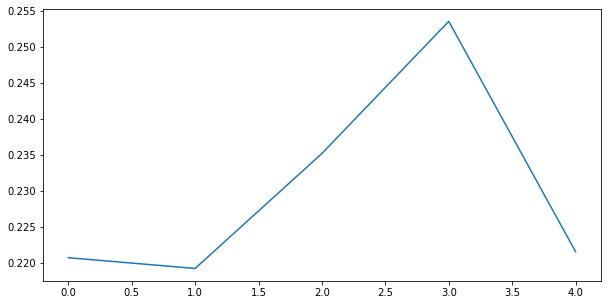

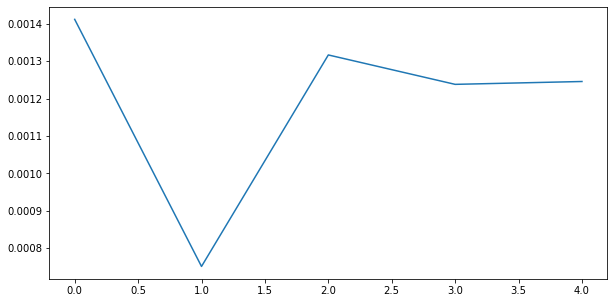

In [154]:
rho1,rho2 = [],[]
tau=20
X,Y = np.array(Xf),np.array(Yf)
for k in range(25):
    if (k>=tau): 
        A = np.zeros((X.shape[1],X.shape[1]))
        for i in range(k-tau,k):
            A+=np.dot(X[i].reshape((X.shape[1],1)),X[i].reshape((X.shape[1],1)).T)
        rho1.append(max(eig(A)[0]))
        rho2.append(min(eig(A)[0]))
        
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(rho1)
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(rho2)

In [174]:
Wf,Wt,Wv

(array([[ 0.10311295],
        [ 0.10123084],
        [ 0.0960112 ],
        [ 0.10443378],
        [ 0.1023155 ],
        [-0.00856086],
        [-0.00942738],
        [-0.00867115],
        [-0.02225101],
        [-0.00752236]]),
 array([[ 0.05366648],
        [ 0.05271701],
        [ 0.05204176],
        [-0.05708323],
        [-0.10482959],
        [ 0.00275909],
        [ 0.00272921],
        [ 0.00128337],
        [ 0.0071825 ],
        [ 0.00978556]]),
 array([[-0.00127611, -0.00126522, -0.00131415],
        [-0.00173954, -0.00134769, -0.00166919],
        [-0.00175777, -0.00160037, -0.00173513],
        [ 0.00367428,  0.00529426,  0.00439937],
        [ 0.0023675 ,  0.00059591,  0.00155823],
        [ 0.00450783,  0.003642  ,  0.00417648],
        [ 0.00560641,  0.00450685,  0.00517591],
        [ 0.00426079,  0.00346761,  0.00395325],
        [ 0.01420662,  0.02327376,  0.01594805],
        [ 0.00875582,  0.00430855,  0.00743045]]))

In [ ]:
Yf